In [1]:

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from tqdm import tqdm
%matplotlib inline


In [2]:
%reload_ext autoreload
%autoreload 2

### import pgqc (pan-genome quality control) toolkit functions
from pgqc.ava import ava
from pgqc.nscluster import clusterBy_KmerJC, summarize_NSClusters, create_MaxKmerSim_JC_Dict, create_MST_FiltByJC, make_ClusterID_Maps 
from pgqc.nscluster import make_NS_ClusterMerged_Pres_DF


from pgqc.utils import parse_PresAbs_Rtab, parse_PresAbs_CSV_Roary, parse_PresAbs_CSV_Panaroo, get_PG_Stats_FromPresAbs

from pgqc.utils import  parse_PG_Ref_FA, get_PG_Stats_FromDNASeqPresAbs, get_PG_Stats_FromPresAbs_V2


from pgqc.asm_gene_search import parse_AlnHits_To_DF
from pgqc.asm_gene_search import PresAbsQC_CheckAsmForGeneSeq, SRAsm_PresAbsQC_CheckInLRAsm
from pgqc.asm_gene_search import get_SRAsm_Vs_LRAsm_QCStats


In [3]:
import time

In [4]:
import screed

In [5]:
import mappy as mp

In [6]:
# Set max column width to a specific value (e.g., 100 characters)
pd.set_option('display.max_colwidth', 100)
# Set to display a specific number of columns (e.g., 20 columns)
pd.set_option('display.max_columns', 180)

# Parse sample metadata & preprocessed genome info/results

In [7]:
!pwd

/n/data1/hms/dbmi/farhat/mm774/Projects/Mtb-VCI-MGM/JupyterNotebooks/240103_2_MtbPangenome_151CI_V5


In [8]:
#!ls -1 ../../Data

## Parse sample Metadata (N = 151)

In [9]:
Repo_DataDir = "../../Data"
InputAsmPath_Dir = f"{Repo_DataDir}/231121.InputAsmTSVs.MtbSetV3.151CI"

MtbSetV3_151CI_InputAsmPATHs_TSV = f"{InputAsmPath_Dir}/231121.MtbSetV3.151CI.HybridAndSRAsm.FAPATHs.V1.tsv"

MtbSetV3_151CI_AsmSumm_TSV = f"{InputAsmPath_Dir}/231121.MtbSetV3.151CI.HybridAsm.AsmSummary.V2.tsv"

WGA151CI_AsmSummary_DF = pd.read_csv(MtbSetV3_151CI_AsmSumm_TSV, sep = "\t")

SampleIDs_151CI_SOI = list( WGA151CI_AsmSummary_DF["SampleID"].values )
WGA151CI_SampleIDs = SampleIDs_151CI_SOI

ID_To_PrimLineage_Dict = dict(WGA151CI_AsmSummary_DF[['SampleID', 'PrimaryLineage']].values)
ID_To_SubLineage_Dict = dict( WGA151CI_AsmSummary_DF[["SampleID", "Lineage"]].values)
ID_To_Dataset_Dict = dict(WGA151CI_AsmSummary_DF[['SampleID', 'Dataset_Tag']].values)
WGA151CI_AsmSummary_DF.shape

(151, 7)

## PARSE PATHs FOR ALL assemblies processed by this pipeline

In [10]:
WGA151CI_LRandSR_Asm_Path_DF = pd.read_csv(MtbSetV3_151CI_InputAsmPATHs_TSV, sep = "\t")
print(WGA151CI_LRandSR_Asm_Path_DF.columns)
WGA151CI_LRandSR_Asm_Path_DF.columns = ['SampleID', 'Dataset_Tag',
                                        'Genome_LR_ASM_PATH', 'Genome_SR_ASM_PATH']


Index(['SampleID', 'Dataset_Tag', 'Genome_ASM_PATH',
       'ShortRead_Genome_ASM_PATH'],
      dtype='object')


In [11]:
WGA151CI_LRandSR_Asm_Path_DF.head(1)

,SampleID,Dataset_Tag,Genome_LR_ASM_PATH,Genome_SR_ASM_PATH
0,N0072,ChinerOms_2019,/n/data1/hms/dbmi/farhat/mm774/Projects/231121.MtbSetV3.151CI.CompleteAndSR.Asms/ChinerOms_2019/...,/n/data1/hms/dbmi/farhat/mm774/Projects/231121.MtbSetV3.151CI.CompleteAndSR.Asms/ChinerOms_2019/...


#### Create Dict of Asm FA PATHs

In [12]:

LR_AsmFA_Dict = dict(WGA151CI_LRandSR_Asm_Path_DF[['SampleID', 'Genome_LR_ASM_PATH']].values)
SR_AsmFA_Dict = dict(WGA151CI_LRandSR_Asm_Path_DF[['SampleID', 'Genome_SR_ASM_PATH']].values)


### Define Phylo order of samples:

In [13]:
OrderOfSampleIDs_Phylo = ['N0153', 'N0072', 'mada_2-46', 'mada_1-44', 'mada_107',
                          'mada_1-1', 'mada_1-51', 'mada_1-39', 'mada_1-36',
                          'mada_117', 'mada_122', 'mada_118', 'mada_1-10', 'R27252',
                          'R23887', 'TB3091', '9050-05', '3003-06', '702-06', '696-05',
                          '8651-04', 'TB3396', '4549-04', 'TB1612', 'TB2780', 'TB3368',
                          'TB1236', 'TB2659', '8129-04', 'R30215', 'R25048', 'TB2512',
                          'TB2981', 'TB2995', 'TB3113', '706-05', 'R30078', 'R28012',
                          'R27657', 'R30234', 'R31095', 'R28703', 'R24120', 'R36431',
                          'R29816', 'S0070-08', 'N0155', 'N0145', 'R29598', 'R24100',
                          'S0107-01', 'R28581', 'S0256-08', 'S0085-01', 'S0089-01',
                          'mada_1-11', 'M0003941_3', 'mada_115', 'mada_2-42', 'R37765',
                          '18_0621851', 'R22601', 'R27937', 'R18040', 'R18043', 'R27725',
                          'R26791', 'R20574', 'R20260', 'R21408', 'R23146', 'R28980', 'R32929',
                          'R26778', 'R30420', 'R21893', 'QC-9', 'QC-5', 'QC-3', 'N0004',
                          'mada_1-30', 'N0054', 'N1274', '01_R1134', 'TB2968', 'mada_1-53',
                          'mada_2-53', 'mada_1-50', 'mada_2-1', 'R23571', 'mada_123',
                          'mada_1-12', 'mada_1-15', 'mada_128', 'mada_1-38', 'TB3054',
                          'mada_126', 'mada_120', 'TB4620', 'M0016737_0', 'M0016395_7',
                          'R15311', 'TB2661', 'TB3386', 'TB3162', '02_R1179', 'M0010874_7',
                          'QC-7', 'QC-6', 'QC-1', '01_R1430', 'M0011368_9', '02_R1896',
                          'mada_2-25', 'TB3237', 'mada_103', 'mada_112', 'mada_124',
                          'S0123-01', 'S0262-02', 'TB3251', 'M0017522_5', 'R30396', 'R20896',
                          'mada_1-32', 'S0106-01', 'R21839', 'R21363', 'R21770', 'MT_0080','mada_102',
                          'TB3334', 'M0014888_3', 'mada_151', 'TB3169', 'mada_105', 'QC-8',
                          'QC-10', 'QC-4', 'mada_129', 'mada_139', '02_R1708', '02_R0894',
                          'mada_2-31', 'mada_1-41', 'N1272', 'N1176', 'N1202', 'N0091',
                          'N1177','RW-TB008']



### Parse Asm QC results

In [14]:
Repo_DataDir = "../../Data"

AsmSummary_TSVs_Dir = Repo_DataDir + "/231130_WGA-Mtb_CompleteVsSR_AsmSummary_TSVs"   

WGA151CI_AsmQCSumm_TSV = f"{AsmSummary_TSVs_Dir}/231130.WGA158CI.LRvsSR.AsmQC.V1.tsv"
WGA151CI_AsmQC_Tidy_TSV = f"{AsmSummary_TSVs_Dir}/231130.WGA158CI.LRvsSR.AsmQC.V1.Tidy.tsv"


WGA151CI_Asm_LRvsSR_DF = pd.read_csv(WGA151CI_AsmQCSumm_TSV, sep="\t")
print(WGA151CI_Asm_LRvsSR_DF.shape)

WGA151CI_Asm_LRvsSR_TidyDF = pd.read_csv(WGA151CI_AsmQC_Tidy_TSV, sep="\t")
print(WGA151CI_Asm_LRvsSR_TidyDF.shape)

(151, 16)
(302, 11)


In [15]:
SRAsm_BUSCO_Dict = WGA151CI_Asm_LRvsSR_DF.set_index('SampleID')['SRAsm_Busco_Complete_Score'].to_dict()   


### Get SampleIDs associated w/ High & Low BUSCO scores (>= 99 or < 99)

In [16]:
WGA151CI_Asm_LRvsSR_DF.query("SRAsm_Busco_Complete_Score >= 99").shape

(136, 16)

In [17]:
WGA151CI_Asm_LRvsSR_DF.query("SRAsm_Busco_Complete_Score < 99").shape

(15, 16)

In [18]:
High_SRBusco_SampleIDs_136CI = WGA151CI_Asm_LRvsSR_DF.query("SRAsm_Busco_Complete_Score >= 99")["SampleID"].values     

Low_SRBusco_SampleIDs_15CI = WGA151CI_Asm_LRvsSR_DF.query("SRAsm_Busco_Complete_Score < 99")["SampleID"].values


In [19]:
Low_SRBusco_SampleIDs_15CI

array(['TB1612', 'TB2981', '02_R1896', 'TB3334', 'N1176', 'N1177',
       'RW-TB008', 'QC-7', 'mada_107', 'R30215', 'R25048', 'R21408',
       'R21770', 'R20896', 'mada_1-38'], dtype=object)

In [20]:
len(Low_SRBusco_SampleIDs_15CI)

15

In [21]:
len(High_SRBusco_SampleIDs_136CI)

136

In [22]:
WGA151CI_AsmSummary_DF.head(5)

,SampleID,numContigs_Complete,Flye_CircContig_Cov,PrimaryLineage,Lineage,Dataset_Tag,AsmApproach
0,N0072,1,358,lineage1,"lineage1,lineage1.1,lineage1.1.2",ChinerOms_2019,PBrs2_LR_Flye_I3_SR_Pilon
1,N0153,1,372,lineage1,"lineage1,lineage1.1,lineage1.1.1,lineage1.1.1.1",ChinerOms_2019,PBrs2_LR_Flye_I3_SR_Pilon
2,TB3113,1,933,lineage2,"lineage2,lineage2.2,lineage2.2.1",TB_Portals_24CI_R1,PBrs2_LR_Flye_I3_SR_Pilon
3,TB1236,1,374,lineage2,"lineage2,lineage2.2,lineage2.2.1",TB_Portals_24CI_R1,PBrs2_LR_Flye_I3_SR_Pilon
4,TB2659,1,421,lineage2,"lineage2,lineage2.2,lineage2.2.1",TB_Portals_24CI_R1,PBrs2_LR_Flye_I3_SR_Pilon


#### Make sample lineage & color mapping

In [23]:
# Dictionary for lineage to color mapping
LinToColor_Dict = {
    "lineage1": "#DF83AC",
    "lineage2": "#7098CB",
    "lineage3": "#815D9F",
    "lineage4": "#E76956",
    "lineage5": "#B67548",
    "lineage6": "#6AB79E",
    "lineage8": "#E4515B",
    "None": "black",
}

# Extracting the mapping between IsolateID and PrimaryLineage_Ill
lineage_mapping = WGA151CI_AsmSummary_DF.set_index('SampleID')['PrimaryLineage'].to_dict()

# Creating a color mapping for the samples
sample_colors = {sample: LinToColor_Dict.get(lineage, "black") for sample, lineage in lineage_mapping.items()}


# Define output dir of the Mtb-WGA-SMK processing pipeline

In [24]:
# Define varaint calling pipeline output directories

WGA_SMK_Outputs_Dir = "/n/data1/hms/dbmi/farhat/mm774/Projects/Mtb-WGA-SMK-Output"

WGA151CI_SMK_OutputDir = WGA_SMK_Outputs_Dir + "/231121_MtbSetV3_151CI"

MtbWGA_SMK_Pipeline_OutputDir = WGA151CI_SMK_OutputDir


## Define output dirs of Pangenome Analysis pipelines

In [25]:
target_OutputDir = MtbWGA_SMK_Pipeline_OutputDir

i_Pangenome_Dir = f"{target_OutputDir}/PanGenome_Analysis"


### Define path to Panaroo output files (158 LR genomes, MergeParalogs Parameters)

In [26]:
# PipeName_WiParam_List = ['Panaroo_Strict_MergeParalogs', 'Panaroo_Moderate_MergeParalogs',
#                          'Panaroo_Sensitive_MergeParalogs', 'Panaroo_Strict',
#                          'Panaroo_Moderate', 'Panaroo_Sensitive',  'Roary_NoSplitParalogs_I80', 'Roary_NoSplitParalogs_I90',
#                          'Roary_NoSplitParalogs',  'Roary_Default', 'Ppanggolin_Default']


PG_OutDir_Dict = { "Panaroo_Strict_MP" : f"{i_Pangenome_Dir}/Panaroo_Strict_MergeParalogs_AllIsolates", 
                     "Panaroo_Moderate_MP" : f"{i_Pangenome_Dir}/Panaroo_Moderate_MergeParalogs_AllIsolates", 
                     "Panaroo_Sens_MP" : f"{i_Pangenome_Dir}/Panaroo_Sensitive_MergeParalogs_AllIsolates",
                     "Roary_Default" : f"{i_Pangenome_Dir}/Roary_Default_AllIsolates",
                     "Roary_NoSplitParalogs" : f"{i_Pangenome_Dir}/Roary_NoSplitParalogs_AllIsolates", 
                     "Roary_NoSplitParalogs_I90" : f"{i_Pangenome_Dir}/Roary_NoSplitParalogs_I90_AllIsolates",
                     "SR_Panaroo_Strict_MP": f"{i_Pangenome_Dir}/SR_Panaroo_Strict_MergeParalogs_AllIsolates",
                     "SR_Panaroo_Moderate_MP": f"{i_Pangenome_Dir}/SR_Panaroo_Moderate_MergeParalogs_AllIsolates",
                     "SR_Panaroo_Sens_MP": f"{i_Pangenome_Dir}/SR_Panaroo_Sensitive_MergeParalogs_AllIsolates",
                     "SR_Roary_Default": f"{i_Pangenome_Dir}/SR_Roary_Default_AllIsolates",
                     "SR_Roary_NoSplitParalogs": f"{i_Pangenome_Dir}/SR_Roary_NoSplitParalogs_AllIsolates",
                     "SR_Roary_NoSplitParalogs_I90": f"{i_Pangenome_Dir}/SR_Roary_NoSplitParalogs_I90_AllIsolates",
                     "SR_Roary_NoSplitParalogs_I80": f"{i_Pangenome_Dir}/SR_Roary_NoSplitParalogs_I80_AllIsolates"
                   }


PG_PresAbs_CSV_PATH_Dict = {}
for i_param, i_outdir in PG_OutDir_Dict.items():
    PG_PresAbs_CSV_PATH_Dict[i_param] = f"{i_outdir}/gene_presence_absence.csv"  
    
PG_PresAbs_Rtab_PATH_Dict = {}
for i_param, i_outdir in PG_OutDir_Dict.items():
    PG_PresAbs_Rtab_PATH_Dict[i_param] = f"{i_outdir}/gene_presence_absence.Rtab"  

PG_GeneRefFA_PATH_Dict = {}
for i_param, i_outdir in PG_OutDir_Dict.items():
    PG_GeneRefFA_PATH_Dict[i_param] = f"{i_outdir}/pan_genome_reference.fa"  

PG_AvA_PATH_Dict = {}
for i_param, i_outdir in PG_OutDir_Dict.items():
    PG_AvA_PATH_Dict[i_param] = f"{i_outdir}/pan_genome_reference.KmerComparison.AllVsAll.MaxJC.tsv"


PG_PresAbs_AsmGeneSeqChk_PATH_Dict = {}
for i_param, i_outdir in PG_OutDir_Dict.items():
    PG_PresAbs_AsmGeneSeqChk_PATH_Dict[i_param] = f"{i_outdir}/gene_presence_absence.AsmGeneSeqChk.tsv"

PG_PresAbs_LRAsmQC_PATH_Dict = {}
for i_param in ["SR_Panaroo_Strict_MP", "SR_Panaroo_Moderate_MP", "SR_Panaroo_Sens_MP", #"SR_Roary_Default",  
                 "SR_Roary_NoSplitParalogs", "SR_Roary_NoSplitParalogs_I90", "SR_Roary_NoSplitParalogs_I80"]:

    i_outdir = PG_OutDir_Dict[i_param]
    PG_PresAbs_LRAsmQC_PATH_Dict[i_param] = f"{i_outdir}/gene_presence_absence.csv.DNAseqQCWiLRAsm.csv" 


In [27]:
#PG_PresAbs_LRAsmQC_PATH_Dict

In [28]:
#PG_GeneRefFA_PATH_Dict

In [29]:
i_PG_Out = PG_OutDir_Dict["Panaroo_Strict_MP"]   

In [30]:
!ls -1 $i_PG_Out  

combined_DNA_CDS.fasta
combined_protein_cdhit_out.txt
combined_protein_cdhit_out.txt.clstr
combined_protein_CDS.fasta
final_graph.gml
gene_data.csv
gene_presence_absence.AsmGeneSeqChk.tsv
gene_presence_absence.csv
gene_presence_absence.NoBakta.Rtab
gene_presence_absence.PGQC.AdjBy.ASC.NSC.Rtab
gene_presence_absence.PGQC.AdjBy.ASC.NSC.tsv
gene_presence_absence.renamed.Rtab
gene_presence_absence_roary.csv
gene_presence_absence.Rtab
NSC_08.Clusters.tsv
pan_genome_reference.fa
pan_genome_reference.KmerComparison.AllVsAll.MaxJC.tsv
Panstripe_AdjByASCandNSC
Panstripe_OG
Panstripe_PhyloAnalysis
pre_filt_graph.gml
struct_presence_absence.Rtab
summary_statistics.txt


In [31]:
i_PG_Out = PG_OutDir_Dict["SR_Roary_NoSplitParalogs_I80"]    

In [32]:
!ls -1 $i_PG_Out  

_1700897361
accessory_binary_genes.fa
accessory_binary_genes.fa.newick
accessory_graph.dot
accessory.header.embl
accessory.tab
blast_identity_frequency.Rtab
clustered_proteins
core_accessory_graph.dot
core_accessory.header.embl
core_accessory.tab
core_alignment_header.embl
core_gene_alignment.aln
fixed_input_files
gene_presence_absence.AsmGeneSeqChk.tsv
gene_presence_absence.csv
gene_presence_absence.csv.DNAseqQCWiLRAsm.csv
gene_presence_absence.Rtab
number_of_conserved_genes.Rtab
number_of_genes_in_pan_genome.Rtab
number_of_new_genes.Rtab
number_of_unique_genes.Rtab
pan_genome_reference.fa
pan_genome_reference.KmerComparison.AllVsAll.MaxJC.tsv
summary_statistics.txt
tmp


# Parse in processed data

### A) Parse in processed All vs All Kmer analysis

In [33]:
AvA_DF_Dict = {}

for i_Param, AvA_TSV_PATH in PG_AvA_PATH_Dict.items():

    PG_AvA_DF = pd.read_csv(AvA_TSV_PATH, sep = "\t" )
    AvA_DF_Dict[i_Param] = PG_AvA_DF


### B) Parse in Gene PresAbs Info

In [34]:
PresAbs_DF_Dict = {}

for i_Param, PresAbs_CSV_PATH in PG_PresAbs_CSV_PATH_Dict.items():

    if "Roary" in i_Param: 
        i_Gene_PresAbs_DF = parse_PresAbs_CSV_Roary(PresAbs_CSV_PATH)
    else:
        i_Gene_PresAbs_DF = parse_PresAbs_CSV_Panaroo(PresAbs_CSV_PATH)

    ### Relabel Columns for presence/absence tracking
    i_Gene_PresAbs_DF.columns = [ x.split(".Bakta")[0] for x in i_Gene_PresAbs_DF.columns ]

    print(i_Param, i_Gene_PresAbs_DF.shape)
    
    PresAbs_DF_Dict[i_Param] = i_Gene_PresAbs_DF
    

/home/mm774/conda3/envs/py37_S/lib/python3.7/site-packages/ipykernel_launcher.py:8: DtypeWarning: Columns (5,10,12,14,16,24,30,31,32,43,44,48,51,57,59,60,61,62,63,64,68,69,70,71,72,73,74,76,79,82,83,84,86,87,88,89,90,91,93,94,95,96,97,98,99,100,101,102,103,104,105,108,109,110,111,112,113,114,116,117,119,121,122,123,124,126,128,130,132,136,137,140,141,142,144,146,147,148,149,150,151,152,153) have mixed types.Specify dtype option on import or set low_memory=False.
  


Panaroo_Strict_MP (4200, 153)


/home/mm774/conda3/envs/py37_S/lib/python3.7/site-packages/ipykernel_launcher.py:8: DtypeWarning: Columns (12,14,16) have mixed types.Specify dtype option on import or set low_memory=False.
  


Panaroo_Moderate_MP (4280, 153)
Panaroo_Sens_MP (4281, 153)
Roary_Default (5366, 153)


/home/mm774/conda3/envs/py37_S/lib/python3.7/site-packages/ipykernel_launcher.py:6: DtypeWarning: Columns (32,41,59,60,68,69,70,71,76,79,81,82,83,84,85,90,93,95,99,100,102,103,104,105,108,110,111,116,117,123,128,131,141,143,146,147,149,157,162,164) have mixed types.Specify dtype option on import or set low_memory=False.
  


Roary_NoSplitParalogs (4366, 153)


/home/mm774/conda3/envs/py37_S/lib/python3.7/site-packages/ipykernel_launcher.py:6: DtypeWarning: Columns (16,18,31,32,35,37,41,52,56,59,60,68,69,70,71,73,76,77,79,80,81,82,83,84,85,90,92,93,95,99,100,102,103,104,105,108,110,111,116,117,123,128,131,136,139,141,143,146,147,149,157,162,164) have mixed types.Specify dtype option on import or set low_memory=False.
  


Roary_NoSplitParalogs_I90 (4293, 153)


/home/mm774/conda3/envs/py37_S/lib/python3.7/site-packages/ipykernel_launcher.py:8: DtypeWarning: Columns (7,13,18,26,29,39,89,110,111,125,134,151) have mixed types.Specify dtype option on import or set low_memory=False.
  


SR_Panaroo_Strict_MP (4211, 153)
SR_Panaroo_Moderate_MP (4382, 153)
SR_Panaroo_Sens_MP (4600, 153)
SR_Roary_Default (6006, 153)
SR_Roary_NoSplitParalogs (5025, 153)
SR_Roary_NoSplitParalogs_I90 (4956, 153)
SR_Roary_NoSplitParalogs_I80 (4866, 153)


### C) Parse in PG Gene Reference FASTAs for each PG output

In [35]:

PG_RefSeqs_DF_Dict = {}

for i_Param, i_PG_Ref_FA_PATH in PG_GeneRefFA_PATH_Dict.items():
    #print(i_PG_Ref_FA_PATH)
    PG_RefSeqs_DF_Dict[i_Param] = parse_PG_Ref_FA(i_PG_Ref_FA_PATH)

    LR_PG_Ref_IDs = list( PG_RefSeqs_DF_Dict[i_Param].keys())
    print(i_Param, len(LR_PG_Ref_IDs))
    

Panaroo_Strict_MP 4200
Panaroo_Moderate_MP 4280
Panaroo_Sens_MP 4281
Roary_Default 5366
Roary_NoSplitParalogs 4366
Roary_NoSplitParalogs_I90 4293
SR_Panaroo_Strict_MP 4211
SR_Panaroo_Moderate_MP 4382
SR_Panaroo_Sens_MP 4600
SR_Roary_Default 6006
SR_Roary_NoSplitParalogs 5025
SR_Roary_NoSplitParalogs_I90 4956
SR_Roary_NoSplitParalogs_I80 4866


## D) PresAbs w/ AsmSeqCheck (For both LR and SR Asms)

In [36]:
PresAbs_DF_AsmSeqChk_Dict = {}


for i_Param, PresAbs_AsmSeqChk_TSV_PATH in PG_PresAbs_AsmGeneSeqChk_PATH_Dict.items():

    i_PresAbs_AsmSeqChk_DF = pd.read_csv(PresAbs_AsmSeqChk_TSV_PATH, sep="\t").set_index("Gene", drop=False)  
    
    PresAbs_DF_AsmSeqChk_Dict[i_Param] = i_PresAbs_AsmSeqChk_DF

    print(i_Param, "-", i_PresAbs_AsmSeqChk_DF.shape)


Panaroo_Strict_MP - (4061, 154)
Panaroo_Moderate_MP - (4280, 154)
Panaroo_Sens_MP - (4281, 154)
Roary_Default - (5366, 154)
Roary_NoSplitParalogs - (4366, 154)
Roary_NoSplitParalogs_I90 - (4293, 154)
SR_Panaroo_Strict_MP - (4211, 154)
SR_Panaroo_Moderate_MP - (4382, 154)
SR_Panaroo_Sens_MP - (4600, 154)
SR_Roary_Default - (6006, 154)
SR_Roary_NoSplitParalogs - (5025, 154)
SR_Roary_NoSplitParalogs_I90 - (4956, 154)
SR_Roary_NoSplitParalogs_I80 - (4866, 154)


## E) PresAbs w/ SR-PG QC using the LR-Asm

In [37]:
i_SampleIDs = SampleIDs_151CI_SOI
Pres_LRAsmQC_Dict = {}

for i_Param, PresAbs_LRAsmQC_TSV_PATH in PG_PresAbs_LRAsmQC_PATH_Dict.items():

    i_PresAbs_LRAsmQC_DF = pd.read_csv(PresAbs_LRAsmQC_TSV_PATH, sep="\t").set_index("Gene", drop=False)  

    i_PresAbs_LRAsmQC_DF["NumAsm_WiGene_AdjByIncompCDSAsm"] = i_PresAbs_LRAsmQC_DF[i_SampleIDs].applymap(lambda x: 1 if x in [1, 3] else 0).sum(axis = 1)
    i_PresAbs_LRAsmQC_DF["NumAsm_WiGene_AdjByIncompCDSAsm_And_CDSAnnoDisc"] = i_PresAbs_LRAsmQC_DF[i_SampleIDs].applymap(lambda x: 1 if x in [1, 3, 4, 5] else 0).sum(axis = 1)

    Pres_LRAsmQC_Dict[i_Param] = i_PresAbs_LRAsmQC_DF

    print(i_Param, "-", i_PresAbs_LRAsmQC_DF.shape)
    #!wc -l $PresAbs_LRAsmQC_CSV_PATH

SR_Panaroo_Strict_MP - (4211, 156)
SR_Panaroo_Moderate_MP - (4382, 156)
SR_Panaroo_Sens_MP - (4600, 156)
SR_Roary_NoSplitParalogs - (5025, 156)
SR_Roary_NoSplitParalogs_I90 - (4956, 156)
SR_Roary_NoSplitParalogs_I80 - (4866, 156)


In [38]:
i_PresAbs_LRAsmQC_DF.columns

Index(['Gene', '01_R1134', '01_R1430', '02_R0894', '02_R1179', '02_R1708',
       '02_R1896', '18_0621851', '3003-06', '4549-04',
       ...
       'mada_2-1', 'mada_2-25', 'mada_2-31', 'mada_2-42', 'mada_2-46',
       'mada_2-53', 'NumAsm_WiGene', 'NumAsm_WiGene_DNASeq',
       'NumAsm_WiGene_AdjByIncompCDSAsm',
       'NumAsm_WiGene_AdjByIncompCDSAsm_And_CDSAnnoDisc'],
      dtype='object', length=156)

In [39]:
#i_PresAbs_LRAsmQC_DF.query("(NumAsm_WiGene_AdjByIncompCDSAsm > 2) & (NumAsm_WiGene_AdjByIncompCDSAsm < 158)")[['Gene', 'NumAsm_WiGene', 'NumAsm_WiGene_DNASeq',  'NumAsm_WiGene_AdjByIncompCDSAsm']]

In [40]:
i_PresAbs_LRAsmQC_DF = Pres_LRAsmQC_Dict["SR_Roary_NoSplitParalogs_I90"]

In [41]:
get_PG_Stats_FromPresAbs_V2(i_PresAbs_LRAsmQC_DF, 151, "NumAsm_WiGene_AdjByIncompCDSAsm")

Accessory Thresh: 149.49
# of core genes: 3596
# of accessory genes: 1360


(4956, 3596, 1360)

In [42]:
i_PresAbs_LRAsmQC_DF = Pres_LRAsmQC_Dict["SR_Panaroo_Moderate_MP"]

In [43]:
get_PG_Stats_FromPresAbs_V2(i_PresAbs_LRAsmQC_DF, 151, "NumAsm_WiGene_AdjByIncompCDSAsm")

Accessory Thresh: 149.49
# of core genes: 3778
# of accessory genes: 604


(4382, 3778, 604)

# Summarize high-level stats for "LRAsm QC" of SR based analysis

### Notes
- 0 means CDS AA seq & DNA seq not found in SR
- 1 means CDS AA seq present in SR
- 3 Means DNA Seq "Not in SR, but In LR Asm", ("Incomplete Assembly")
- 4 Means DNA Seq "In SR Asm, NOT In LR Asm" 
- 5 Means DNA Seq "In SR Asm, In LR Asm" ("Annotation Discrepancy")


In [44]:
ListOf_SampleID_Cols = SampleIDs_151CI_SOI

In [45]:
listOfRows = []

for i_Param, i_PresAbs_LRAsmQC_DF in Pres_LRAsmQC_Dict.items():

    print(i_Param)

    i_Counts = get_SRAsm_Vs_LRAsm_QCStats(i_PresAbs_LRAsmQC_DF, ListOf_SampleID_Cols, False)
    NAbs_0, NPres_1, NAbs_DNAInLR_3, NAbs_DNAInSR_4, NAbs_DNAInSRandLR_5 = i_Counts

    listOfRows.append((i_Param, NAbs_0, NPres_1, NAbs_DNAInLR_3, NAbs_DNAInSR_4, NAbs_DNAInSRandLR_5)  )
    
    #print("\n\n\n")



Summ_DF = pd.DataFrame(listOfRows)

Summ_DF.columns = ["Param", "NAbs_0", "NPres_1", "NAbs_DNAInLR_3", "NAbs_DNAInSR_4", "NAbs_DNAInSRandLR_5"]

Summ_DF["NAbs_AnnoDiscrep"] = Summ_DF["NAbs_DNAInSR_4"] + Summ_DF["NAbs_DNAInSRandLR_5"]
Summ_DF["NAbs_IncompAsm"] = Summ_DF["NAbs_DNAInLR_3"]
Summ_DF["NAbs_Total"] = Summ_DF["NAbs_0"] + Summ_DF["NAbs_DNAInLR_3"] + Summ_DF["NAbs_DNAInSR_4"] + Summ_DF["NAbs_DNAInSRandLR_5"] 

Summ_DF["PercAbs_0"] = Summ_DF["NAbs_0"] / Summ_DF["NAbs_Total"] * 100
Summ_DF["PercAbs_DNAInLR_3"] = Summ_DF["NAbs_DNAInLR_3"] / Summ_DF["NAbs_Total"] * 100
Summ_DF["PercAbs_DNAInSR_4"] = Summ_DF["NAbs_DNAInSR_4"] / Summ_DF["NAbs_Total"] * 100
Summ_DF["PercAbs_DNAInSRandLR_5"] = Summ_DF["NAbs_DNAInSRandLR_5"] / Summ_DF["NAbs_Total"] * 100

Perc_Cols = ["PercAbs_0", "PercAbs_DNAInLR_3", "PercAbs_DNAInSR_4", "PercAbs_DNAInSRandLR_5"]

Summ_DF[Perc_Cols] = Summ_DF[Perc_Cols].round(2)

Summ_DF["PercAbs_AnnoDiscrep"] = Summ_DF["PercAbs_DNAInSR_4"] + Summ_DF["PercAbs_DNAInSRandLR_5"] 
Summ_DF["PercAbs_IncompAsm"] = Summ_DF["PercAbs_DNAInLR_3"]


SRPG_LRQC_Summ_DF = Summ_DF

SR_Panaroo_Strict_MP
SR_Panaroo_Moderate_MP
SR_Panaroo_Sens_MP
SR_Roary_NoSplitParalogs
SR_Roary_NoSplitParalogs_I90
SR_Roary_NoSplitParalogs_I80


In [46]:
SRPG_LRQC_Summ_DF.to_csv("./Data/SRPG_LRQC_Summ_DF.tsv", sep="\t", index=False)

In [47]:
SRPG_LRQC_Summ_DF

,Param,NAbs_0,NPres_1,NAbs_DNAInLR_3,NAbs_DNAInSR_4,NAbs_DNAInSRandLR_5,NAbs_AnnoDiscrep,NAbs_IncompAsm,NAbs_Total,PercAbs_0,PercAbs_DNAInLR_3,PercAbs_DNAInSR_4,PercAbs_DNAInSRandLR_5,PercAbs_AnnoDiscrep,PercAbs_IncompAsm
0,SR_Panaroo_Strict_MP,15053,600688,4514,47,15559,15606,4514,35173,42.80,12.83,0.13,44.24,44.37,12.83
1,SR_Panaroo_Moderate_MP,20324,609813,6569,85,24891,24976,6569,51869,39.18,12.66,0.16,47.99,48.15,12.66
2,SR_Panaroo_Sens_MP,34079,610926,9451,139,40005,40144,9451,83674,40.73,11.30,0.17,47.81,47.98,11.30
3,SR_Roary_NoSplitParalogs,50300,597507,12038,90,98840,98930,12038,161268,31.19,7.46,0.06,61.29,61.35,7.46
4,SR_Roary_NoSplitParalogs_I90,46473,597068,10993,88,93734,93822,10993,151288,30.72,7.27,0.06,61.96,62.02,7.27
5,SR_Roary_NoSplitParalogs_I80,41820,592992,10240,75,89639,89714,10240,141774,29.50,7.22,0.05,63.23,63.28,7.22


In [48]:
LRQC_SimpCol = ["Param", "NAbs_0", "NPres_1", "NAbs_AnnoDiscrep", "NAbs_IncompAsm", "NAbs_Total", "PercAbs_AnnoDiscrep", "PercAbs_IncompAsm"]     

SRPG_LRQC_Summ_DF[LRQC_SimpCol]

,Param,NAbs_0,NPres_1,NAbs_AnnoDiscrep,NAbs_IncompAsm,NAbs_Total,PercAbs_AnnoDiscrep,PercAbs_IncompAsm
0,SR_Panaroo_Strict_MP,15053,600688,15606,4514,35173,44.37,12.83
1,SR_Panaroo_Moderate_MP,20324,609813,24976,6569,51869,48.15,12.66
2,SR_Panaroo_Sens_MP,34079,610926,40144,9451,83674,47.98,11.30
3,SR_Roary_NoSplitParalogs,50300,597507,98930,12038,161268,61.35,7.46
4,SR_Roary_NoSplitParalogs_I90,46473,597068,93822,10993,151288,62.02,7.27
5,SR_Roary_NoSplitParalogs_I80,41820,592992,89714,10240,141774,63.28,7.22


In [49]:
#SRPG_LRQC_Summ_DF.to_csv("./Data/SRPG_LRQC_Summ_DF"

In [50]:
15053 + 15606 + 4514

35173

In [51]:
6569 + 24976 + 20324

51869

# Adjust PG analysis by different absence explanations

In [52]:
N_Genomes = len(ListOf_SampleID_Cols)
N_Genomes

151

In [53]:
listOfRows = []


for i_Param, _ in Pres_LRAsmQC_Dict.items():
    print(i_Param)

    N_Total, N_Core, N_Acc = get_PG_Stats_FromPresAbs(PresAbs_DF_AsmSeqChk_Dict[i_Param], N_Genomes)

    i_row = (i_Param, "Original", N_Total, N_Core, N_Acc)
    listOfRows.append(i_row)
    print()
    N_Total, N_Core, N_Acc = get_PG_Stats_FromDNASeqPresAbs(PresAbs_DF_AsmSeqChk_Dict[i_Param], N_Genomes)
    print()
    i_row = (i_Param, "AdjustBy_CDSAnnoDisc", N_Total, N_Core, N_Acc)
    listOfRows.append(i_row)
    print()
    N_Total, N_Core, N_Acc = get_PG_Stats_FromPresAbs_V2(Pres_LRAsmQC_Dict[i_Param], N_Genomes, "NumAsm_WiGene_AdjByIncompCDSAsm")
    i_row = (i_Param, "AdjustBy_IncompAsm", N_Total, N_Core, N_Acc)
    listOfRows.append(i_row)

    N_Total, N_Core, N_Acc = get_PG_Stats_FromPresAbs_V2(Pres_LRAsmQC_Dict[i_Param], N_Genomes, "NumAsm_WiGene_AdjByIncompCDSAsm_And_CDSAnnoDisc")
    i_row = (i_Param, "AdjustBy_IncompAsm_And_CDSAnnoDisc", N_Total, N_Core, N_Acc)
    listOfRows.append(i_row)

    print("-"*20, "\n")


PG_Summ_SRQC_Adj_DF = pd.DataFrame(listOfRows)

PG_Summ_SRQC_Adj_DF.columns = ["Param", "Approach", "Total", "Core", "Accessory"]


SR_Panaroo_Strict_MP
Accessory Thresh: 149.49

Accessory Thresh: 149.49


Accessory Thresh: 149.49
# of core genes: 3736
# of accessory genes: 475
Accessory Thresh: 149.49
# of core genes: 3893
# of accessory genes: 318
-------------------- 

SR_Panaroo_Moderate_MP
Accessory Thresh: 149.49

Accessory Thresh: 149.49


Accessory Thresh: 149.49
# of core genes: 3778
# of accessory genes: 604
Accessory Thresh: 149.49
# of core genes: 3991
# of accessory genes: 391
-------------------- 

SR_Panaroo_Sens_MP
Accessory Thresh: 149.49

Accessory Thresh: 149.49


Accessory Thresh: 149.49
# of core genes: 3780
# of accessory genes: 820
Accessory Thresh: 149.49
# of core genes: 4077
# of accessory genes: 523
-------------------- 

SR_Roary_NoSplitParalogs
Accessory Thresh: 149.49

Accessory Thresh: 149.49


Accessory Thresh: 149.49
# of core genes: 3589
# of accessory genes: 1436
Accessory Thresh: 149.49
# of core genes: 4349
# of accessory genes: 676
-------------------- 

SR_Roary_NoSplitParalog

In [54]:
PG_Summ_SRQC_Adj_DF

,Param,Approach,Total,Core,Accessory
0,SR_Panaroo_Strict_MP,Original,4211,3537,674
1,SR_Panaroo_Strict_MP,AdjustBy_CDSAnnoDisc,4211,3642,569
2,SR_Panaroo_Strict_MP,AdjustBy_IncompAsm,4211,3736,475
3,SR_Panaroo_Strict_MP,AdjustBy_IncompAsm_And_CDSAnnoDisc,4211,3893,318
4,SR_Panaroo_Moderate_MP,Original,4382,3574,808
5,SR_Panaroo_Moderate_MP,AdjustBy_CDSAnnoDisc,4382,3712,670
6,SR_Panaroo_Moderate_MP,AdjustBy_IncompAsm,4382,3778,604
7,SR_Panaroo_Moderate_MP,AdjustBy_IncompAsm_And_CDSAnnoDisc,4382,3991,391
8,SR_Panaroo_Sens_MP,Original,4600,3576,1024
9,SR_Panaroo_Sens_MP,AdjustBy_CDSAnnoDisc,4600,3766,834


In [55]:
PG_Summ_SRQC_Adj_DF.query("Param == 'SR_Panaroo_Moderate'")

,Param,Approach,Total,Core,Accessory


In [56]:
PG_Summ_SRQC_Adj_DF.query("Approach == 'AdjustBy_IncompAsm_And_CDSAnnoDisc'")

,Param,Approach,Total,Core,Accessory
3,SR_Panaroo_Strict_MP,AdjustBy_IncompAsm_And_CDSAnnoDisc,4211,3893,318
7,SR_Panaroo_Moderate_MP,AdjustBy_IncompAsm_And_CDSAnnoDisc,4382,3991,391
11,SR_Panaroo_Sens_MP,AdjustBy_IncompAsm_And_CDSAnnoDisc,4600,4077,523
15,SR_Roary_NoSplitParalogs,AdjustBy_IncompAsm_And_CDSAnnoDisc,5025,4349,676
19,SR_Roary_NoSplitParalogs_I90,AdjustBy_IncompAsm_And_CDSAnnoDisc,4956,4316,640
23,SR_Roary_NoSplitParalogs_I80,AdjustBy_IncompAsm_And_CDSAnnoDisc,4866,4277,589


In [57]:
# for i_Param, _ in Pres_LRAsmQC_Dict.items():
#     print(i_Param)

#     N_Total, N_Core, N_Acc = get_PG_Stats_FromPresAbs(PresAbs_DF_AsmSeqChk_Dict[i_Param], N_Genomes)

#     i_row = (i_Param, "Original", N_Total, N_Core, N_Acc)
#     #listOfRows.append(i_row)
#     print()
#     N_Total, N_Core, N_Acc = get_PG_Stats_FromDNASeqPresAbs(PresAbs_DF_AsmSeqChk_Dict[i_Param], N_Genomes)
#     i_row = (i_Param, "AdjustBy_DNASeq", N_Total, N_Core, N_Acc)
#     #listOfRows.append(i_row)

#     N_Total, N_Core, N_Acc = get_PG_Stats_FromDNASeqPresAbs(Pres_LRAsmQC_Dict[i_Param], N_Genomes)

    
#     print("-"*20, "\n")

## Extra - Exploration of PG numbers before and after `AsmGeneSeqSearch` step

In [58]:
N_Genomes = len(ListOf_SampleID_Cols)
N_Genomes

151

In [59]:
listOfRows = []

for i_Param, _ in Pres_LRAsmQC_Dict.items():
    print(i_Param)

    N_Total, N_Core, N_Acc = get_PG_Stats_FromPresAbs(PresAbs_DF_AsmSeqChk_Dict[i_Param], N_Genomes)

    i_row = (i_Param, "Original", N_Total, N_Core, N_Acc)
    listOfRows.append(i_row)

    N_Total, N_Core, N_Acc = get_PG_Stats_FromDNASeqPresAbs(PresAbs_DF_AsmSeqChk_Dict[i_Param], N_Genomes)

    i_row = (i_Param, "AdjustBy_DNASeq", N_Total, N_Core, N_Acc)
    listOfRows.append(i_row)
    
    print("-"*20, "\n")


PG_Summ_SROnly_DF = pd.DataFrame(listOfRows)

PG_Summ_SROnly_DF.columns = ["Param", "Approach", "Total", "Core", "Accessory"]


SR_Panaroo_Strict_MP
Accessory Thresh: 149.49
Accessory Thresh: 149.49
-------------------- 

SR_Panaroo_Moderate_MP
Accessory Thresh: 149.49
Accessory Thresh: 149.49
-------------------- 

SR_Panaroo_Sens_MP
Accessory Thresh: 149.49
Accessory Thresh: 149.49
-------------------- 

SR_Roary_NoSplitParalogs
Accessory Thresh: 149.49
Accessory Thresh: 149.49
-------------------- 

SR_Roary_NoSplitParalogs_I90
Accessory Thresh: 149.49
Accessory Thresh: 149.49
-------------------- 

SR_Roary_NoSplitParalogs_I80
Accessory Thresh: 149.49
Accessory Thresh: 149.49
-------------------- 



In [60]:
PG_Summ_SROnly_DF

,Param,Approach,Total,Core,Accessory
0,SR_Panaroo_Strict_MP,Original,4211,3537,674
1,SR_Panaroo_Strict_MP,AdjustBy_DNASeq,4211,3642,569
2,SR_Panaroo_Moderate_MP,Original,4382,3574,808
3,SR_Panaroo_Moderate_MP,AdjustBy_DNASeq,4382,3712,670
4,SR_Panaroo_Sens_MP,Original,4600,3576,1024
5,SR_Panaroo_Sens_MP,AdjustBy_DNASeq,4600,3766,834
6,SR_Roary_NoSplitParalogs,Original,5025,3318,1707
7,SR_Roary_NoSplitParalogs,AdjustBy_DNASeq,5025,3916,1109
8,SR_Roary_NoSplitParalogs_I90,Original,4956,3326,1630
9,SR_Roary_NoSplitParalogs_I90,AdjustBy_DNASeq,4956,3893,1063


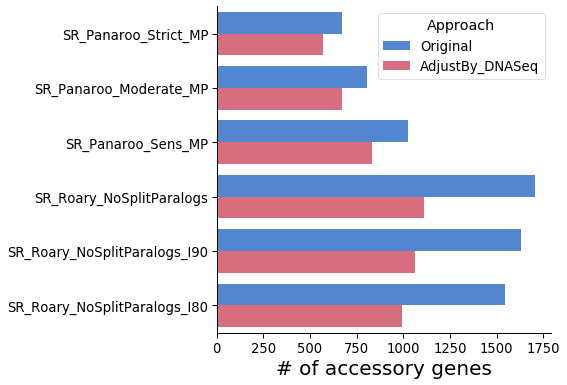

In [61]:
sns.set_context("paper", font_scale=1.5)

fig, axs = plt.subplots(1, 1, figsize= (6, 6), sharex=True)

sns.barplot(y = "Param", x = "Accessory", hue = "Approach",
            data = PG_Summ_SROnly_DF, ax = axs, palette = ["#3F84E5", "#E85D75", "red", "purple"] )

# Add a legend outside of the plot to the right
#plt.legend(loc='upper left', bbox_to_anchor=(1, 1))

plt.ylabel("")
axs.set_xlabel("# of accessory genes", fontsize = 20)
sns.despine()
plt.show()

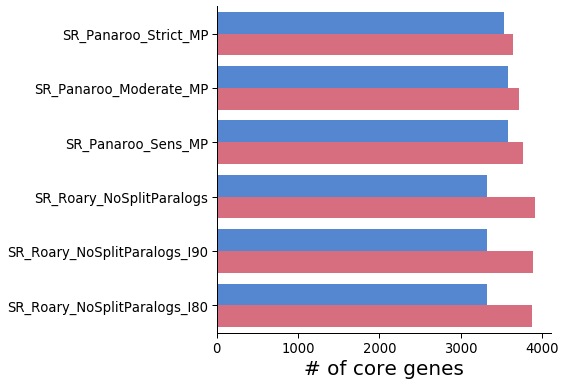

In [62]:
sns.set_context("paper", font_scale=1.5)

fig, axs = plt.subplots(1, 1, figsize= (6, 6), sharex=True)

sns.barplot(y = "Param", x = "Core", hue = "Approach",
            data = PG_Summ_SROnly_DF, ax = axs, palette = ["#3F84E5", "#E85D75", "red", "purple"], )

# Add a legend outside of the plot to the right
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.gca().legend().set_visible(False)

plt.ylabel("")
axs.set_xlabel("# of core genes", fontsize = 20)
sns.despine()
plt.show()

In [63]:
listOfRows = []

for i_Param, _ in Pres_LRAsmQC_Dict.items():
    print(i_Param)

    OG_N_Total, OG_N_Core, OG_N_Acc = get_PG_Stats_FromPresAbs(PresAbs_DF_AsmSeqChk_Dict[i_Param], N_Genomes)

    Adj_N_Total, Adj_N_Core, Adj_N_Acc = get_PG_Stats_FromDNASeqPresAbs(PresAbs_DF_AsmSeqChk_Dict[i_Param], N_Genomes)

    
    i_row = (i_Param, OG_N_Total, OG_N_Core, OG_N_Acc, Adj_N_Total, Adj_N_Core, Adj_N_Acc)
    listOfRows.append(i_row)
    
    print("-"*20, "\n")


PG_SR_LRAsmQC_DiffSumm_DF = pd.DataFrame(listOfRows)

PG_SR_LRAsmQC_DiffSumm_DF.columns = ["Param", "OG_Total", "OG_Core", "OG_Accessory", "DNAAdj_Total", "DNAAdj_Core", "DNAAdj_Accessory"]

PG_SR_LRAsmQC_DiffSumm_DF["Diff_Core"] =  PG_SR_LRAsmQC_DiffSumm_DF["DNAAdj_Core"] - PG_SR_LRAsmQC_DiffSumm_DF["OG_Core"]
PG_SR_LRAsmQC_DiffSumm_DF["Diff_Accessory"] = PG_SR_LRAsmQC_DiffSumm_DF["DNAAdj_Accessory"] -  PG_SR_LRAsmQC_DiffSumm_DF["OG_Accessory"]


SR_Panaroo_Strict_MP
Accessory Thresh: 149.49
Accessory Thresh: 149.49
-------------------- 

SR_Panaroo_Moderate_MP
Accessory Thresh: 149.49
Accessory Thresh: 149.49
-------------------- 

SR_Panaroo_Sens_MP
Accessory Thresh: 149.49
Accessory Thresh: 149.49
-------------------- 

SR_Roary_NoSplitParalogs
Accessory Thresh: 149.49
Accessory Thresh: 149.49
-------------------- 

SR_Roary_NoSplitParalogs_I90
Accessory Thresh: 149.49
Accessory Thresh: 149.49
-------------------- 

SR_Roary_NoSplitParalogs_I80
Accessory Thresh: 149.49
Accessory Thresh: 149.49
-------------------- 



In [64]:
PG_SR_LRAsmQC_DiffSumm_DF

,Param,OG_Total,OG_Core,OG_Accessory,DNAAdj_Total,DNAAdj_Core,DNAAdj_Accessory,Diff_Core,Diff_Accessory
0,SR_Panaroo_Strict_MP,4211,3537,674,4211,3642,569,105,-105
1,SR_Panaroo_Moderate_MP,4382,3574,808,4382,3712,670,138,-138
2,SR_Panaroo_Sens_MP,4600,3576,1024,4600,3766,834,190,-190
3,SR_Roary_NoSplitParalogs,5025,3318,1707,5025,3916,1109,598,-598
4,SR_Roary_NoSplitParalogs_I90,4956,3326,1630,4956,3893,1063,567,-567
5,SR_Roary_NoSplitParalogs_I80,4866,3324,1542,4866,3874,992,550,-550


In [65]:
# listOfRows = []


# for i_param in list( PG_Summ_SROnly_DF["Param"].unique() ):


# PG_SR_LRAsmQC_DiffSumm_DF = pd.DataFrame(listOfRows)

# PG_Summ_SROnly_DF.columns = ["Param", "Approach", "Total", "Core", "Accessory"]


    

In [66]:
for i_param in list( PG_Summ_SROnly_DF["Param"].unique() ):

    i_OG_Acc_Size = PG_Summ_SROnly_DF.query(f"Param == '{i_param}' & Approach == 'Original' ")["Accessory"].values[0]   

    i_Adjust_Acc_Size = PG_Summ_SROnly_DF.query(f"Param == '{i_param}' & Approach == 'AdjustBy_DNASeq' ")["Accessory"].values[0]   

    Perc_Decrease = ((i_OG_Acc_Size - i_Adjust_Acc_Size) / i_Adjust_Acc_Size) * 100

    print(i_param, i_OG_Acc_Size, i_Adjust_Acc_Size, Perc_Decrease)
        

SR_Panaroo_Strict_MP 674 569 18.45342706502636
SR_Panaroo_Moderate_MP 808 670 20.597014925373134
SR_Panaroo_Sens_MP 1024 834 22.781774580335732
SR_Roary_NoSplitParalogs 1707 1109 53.9224526600541
SR_Roary_NoSplitParalogs_I90 1630 1063 53.33960489181562
SR_Roary_NoSplitParalogs_I80 1542 992 55.443548387096776


In [67]:
#PG_Summ_DF

In [68]:
# sns.set_context("paper", font_scale=1.5)

# fig, axs = plt.subplots(1, 1, figsize= (12, 10), sharex=True)

# sns.barplot(y = "Param", x = "Accessory", hue = "Approach",
#             data = PG_Summ_DF, ax = axs, palette = ["#3F84E5", "#E85D75", "red", "purple"] )

# # Add a legend outside of the plot to the right
# plt.legend(loc='upper left', bbox_to_anchor=(1, 1))

# axs.set_xlabel("# of accessory genes", fontsize = 20)
# sns.despine()
# plt.show()

In [69]:
!pgqc --help

INFO:numexpr.utils:Note: NumExpr detected 28 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
usage: pgqc [-h] {asmseqcheck,ava,nscluster} ...

Toolkit for focused on augmenting Panaroo's pan-genome analysis with
nucleotide sequence comparison.

positional arguments:
  {asmseqcheck,ava,nscluster}
                        Please select one of the pipelines of the PGQC
                        toolkit.

optional arguments:
  -h, --help            show this help message and exit


## Dev code for exploring LR Asm QC Steps

In [70]:
print(Pres_LRAsmQC_Dict.keys())

dict_keys(['SR_Panaroo_Strict_MP', 'SR_Panaroo_Moderate_MP', 'SR_Panaroo_Sens_MP', 'SR_Roary_NoSplitParalogs', 'SR_Roary_NoSplitParalogs_I90', 'SR_Roary_NoSplitParalogs_I80'])


In [71]:
i_SampleIDs = SampleIDs_151CI_SOI
TDF = Pres_LRAsmQC_Dict["SR_Panaroo_Strict_MP"]
TDF = Pres_LRAsmQC_Dict["SR_Panaroo_Sens_MP"]

TDF = Pres_LRAsmQC_Dict["SR_Roary_NoSplitParalogs"]


#TDF.head(2)

In [72]:
print((TDF[i_SampleIDs] == 0).sum().sum() )
print((TDF[i_SampleIDs] == 1).sum().sum() )
print((TDF[i_SampleIDs] == 2).sum().sum() )
print((TDF[i_SampleIDs] == 3).sum().sum() )
print((TDF[i_SampleIDs] == 4).sum().sum() )
print((TDF[i_SampleIDs] == 5).sum().sum())

50300
597507
0
12038
90
98840


In [73]:
AnnDisc_sorted_series = (TDF[i_SampleIDs] == 5).sum() .sort_values(ascending=False)
IncompAsm_sorted_series = (TDF[i_SampleIDs] == 3).sum() .sort_values(ascending=False)

### Notes
- 0 means CDS AA seq & DNA seq not found in SR
- 1 means CDS AA seq present in SR
- 3 Means DNA Seq "Not in SR, but In LR Asm", ("Incomplete Assembly")
- 4 Means DNA Seq "In SR Asm, NOT In LR Asm" 
- 5 Means DNA Seq "In SR Asm, In LR Asm" ("Annotation Discrepancy")


In [74]:
IncompAsm_sorted_series

R25048      387
R21770      294
N1177       244
QC-7        211
R21408      166
           ... 
02_R1179     23
S0262-02     22
MT_0080      21
S0256-08     20
S0106-01     14
Length: 151, dtype: int64

In [75]:
AnnDisc_sorted_series

MT_0080       731
S0106-01      728
TB3396        719
M0016737_0    717
02_R1179      713
             ... 
18_0621851    576
R21408        564
N1177         527
R21770        523
R25048        492
Length: 151, dtype: int64

### MannWhitney-U test for difference in "anno discrep" and "Incomplete Assembly" numbers

In [76]:
from scipy.stats import mannwhitneyu

In [77]:
IncompAsm_LoBUSCO_Ct = (TDF[SampleIDs_151CI_SOI] == 3).sum().loc[Low_SRBusco_SampleIDs_15CI] 
IncompAsm_HighBUSCO_Ct = (TDF[SampleIDs_151CI_SOI] == 3).sum().loc[High_SRBusco_SampleIDs_136CI] 

# Perform Mann-Whitney U test
statistic, IncompAsm_p_value = mannwhitneyu(IncompAsm_LoBUSCO_Ct,
                                  IncompAsm_HighBUSCO_Ct, alternative="two-sided")

print(statistic, IncompAsm_p_value)

1713.5 1.6214364878126202e-05


In [78]:
AnnoDiscrep_LoBUSCO_Ct = (TDF[SampleIDs_151CI_SOI] == 5).sum().loc[Low_SRBusco_SampleIDs_15CI] 
AnnoDiscrep_HighBUSCO_Ct = (TDF[SampleIDs_151CI_SOI] == 5).sum().loc[High_SRBusco_SampleIDs_136CI] 

# Perform Mann-Whitney U test
statistic, AnnoDiscrep_p_value = mannwhitneyu(AnnoDiscrep_LoBUSCO_Ct,
                                  AnnoDiscrep_HighBUSCO_Ct, alternative="two-sided")

print(statistic, AnnoDiscrep_p_value)

546.0 0.003220378018421066


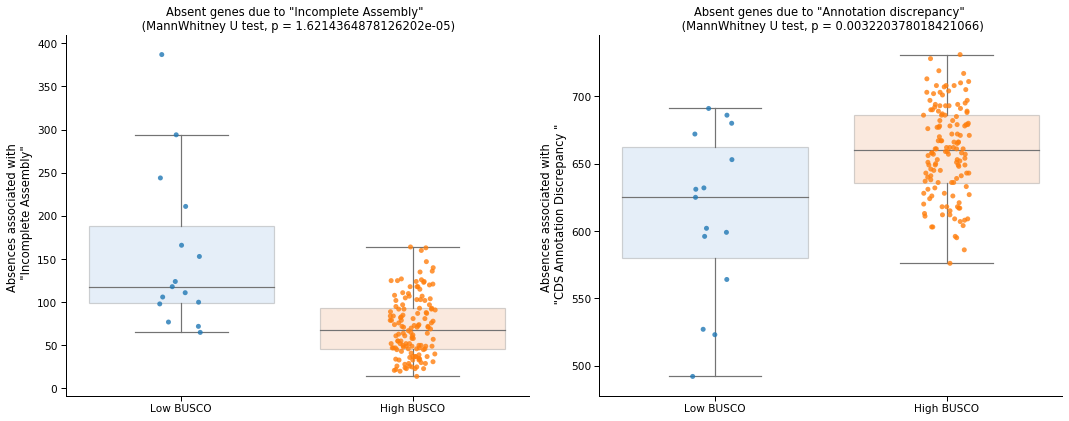

In [79]:
sns.set_context("paper", font_scale=1.2)

# Combine the data and label them for plotting
data_IncompAsm = pd.concat([IncompAsm_LoBUSCO_Ct, IncompAsm_HighBUSCO_Ct])
data_AnnoDiscrep = pd.concat([AnnoDiscrep_LoBUSCO_Ct, AnnoDiscrep_HighBUSCO_Ct])

labels = ['Low BUSCO'] * len(AnnoDiscrep_LoBUSCO_Ct) + ['High BUSCO'] * len(AnnoDiscrep_HighBUSCO_Ct)

# Create a DataFrame for plotting
import pandas as pd
df_SRAsmQC = pd.DataFrame({
    'Group': labels,
    'N_IncompAsm': data_IncompAsm,
    'N_AnnoDiscrep': data_AnnoDiscrep,
})

df_SRAsmQC["SRAsm_BUSCO"] = df_SRAsmQC.index.map(SRAsm_BUSCO_Dict).astype(float)

# Create two subplots side by side
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 6))
#fig.suptitle('Comparison of High and Low BUSCO SR Assemblies', fontsize=16, y = 1.05)

# Plot
sns.boxplot(x='Group', y='N_IncompAsm', data=df_SRAsmQC, palette="pastel", boxprops=dict(alpha=.3), fliersize=0, ax=axes[0])
sns.stripplot(x='Group', y='N_IncompAsm', data=df_SRAsmQC, jitter=True, marker='o', alpha=0.8, edgecolor='gray', ax=axes[0])

axes[0].set_title(f'Absent genes due to "Incomplete Assembly" \n (MannWhitney U test, p = {IncompAsm_p_value})')
axes[0].set_ylabel('Absences associated with \n  "Incomplete Assembly"')
axes[0].set_xlabel('')
sns.despine(ax=axes[0])


sns.boxplot(x='Group', y='N_AnnoDiscrep', data=df_SRAsmQC, palette="pastel", boxprops=dict(alpha=.3), fliersize=0, ax=axes[1])
sns.stripplot(x='Group', y='N_AnnoDiscrep', data=df_SRAsmQC, jitter=True, marker='o', alpha=0.8, edgecolor='gray', ax=axes[1])

axes[1].set_title(f'Absent genes due to "Annotation discrepancy" \n (MannWhitney U test, p = {AnnoDiscrep_p_value})')
axes[1].set_ylabel('Absences associated with \n "CDS Annotation Discrepancy "')
axes[1].set_xlabel('')
sns.despine(ax=axes[1])

# Remove grid lines
axes[0].grid(False)
axes[1].grid(False)


# Adjust layout to prevent overlap
plt.tight_layout()

plt.show()

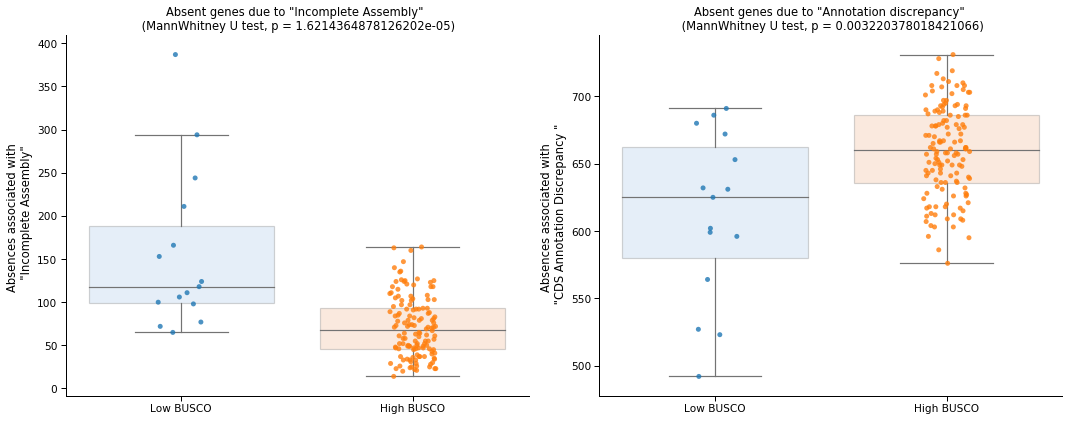

In [80]:
sns.set_context("paper", font_scale=1.2)

# Combine the data and label them for plotting
data_IncompAsm = pd.concat([IncompAsm_LoBUSCO_Ct, IncompAsm_HighBUSCO_Ct])
data_AnnoDiscrep = pd.concat([AnnoDiscrep_LoBUSCO_Ct, AnnoDiscrep_HighBUSCO_Ct])

labels = ['Low BUSCO'] * len(AnnoDiscrep_LoBUSCO_Ct) + ['High BUSCO'] * len(AnnoDiscrep_HighBUSCO_Ct)

# Create a DataFrame for plotting
import pandas as pd
df_SRAsmQC = pd.DataFrame({
    'Group': labels,
    'N_IncompAsm': data_IncompAsm,
    'N_AnnoDiscrep': data_AnnoDiscrep,
})

df_SRAsmQC["SRAsm_BUSCO"] = df_SRAsmQC.index.map(SRAsm_BUSCO_Dict).astype(float)

# Create two subplots side by side
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 6))
#fig.suptitle('Comparison of High and Low BUSCO SR Assemblies', fontsize=16, y = 1.05)

# Plot
sns.boxplot(x='Group', y='N_IncompAsm', data=df_SRAsmQC, palette="pastel", boxprops=dict(alpha=.3), fliersize=0, ax=axes[0])
sns.stripplot(x='Group', y='N_IncompAsm', data=df_SRAsmQC, jitter=True, marker='o', alpha=0.8, edgecolor='gray', ax=axes[0])

axes[0].set_title(f'Absent genes due to "Incomplete Assembly" \n (MannWhitney U test, p = {IncompAsm_p_value})')
axes[0].set_ylabel('Absences associated with \n  "Incomplete Assembly"')
axes[0].set_xlabel('')
sns.despine(ax=axes[0])


sns.boxplot(x='Group', y='N_AnnoDiscrep', data=df_SRAsmQC, palette="pastel", boxprops=dict(alpha=.3), fliersize=0, ax=axes[1])
sns.stripplot(x='Group', y='N_AnnoDiscrep', data=df_SRAsmQC, jitter=True, marker='o', alpha=0.8, edgecolor='gray', ax=axes[1])

axes[1].set_title(f'Absent genes due to "Annotation discrepancy" \n (MannWhitney U test, p = {AnnoDiscrep_p_value})')
axes[1].set_ylabel('Absences associated with \n "CDS Annotation Discrepancy "')
axes[1].set_xlabel('')
sns.despine(ax=axes[1])

# Remove grid lines
axes[0].grid(False)
axes[1].grid(False)


# Adjust layout to prevent overlap
plt.tight_layout()

plt.show()

In [81]:
sns.set_style(None)
plt.style.use('./nqo.mplstyle')

mkdir: cannot create directory ‘Results4_Plots’: File exists


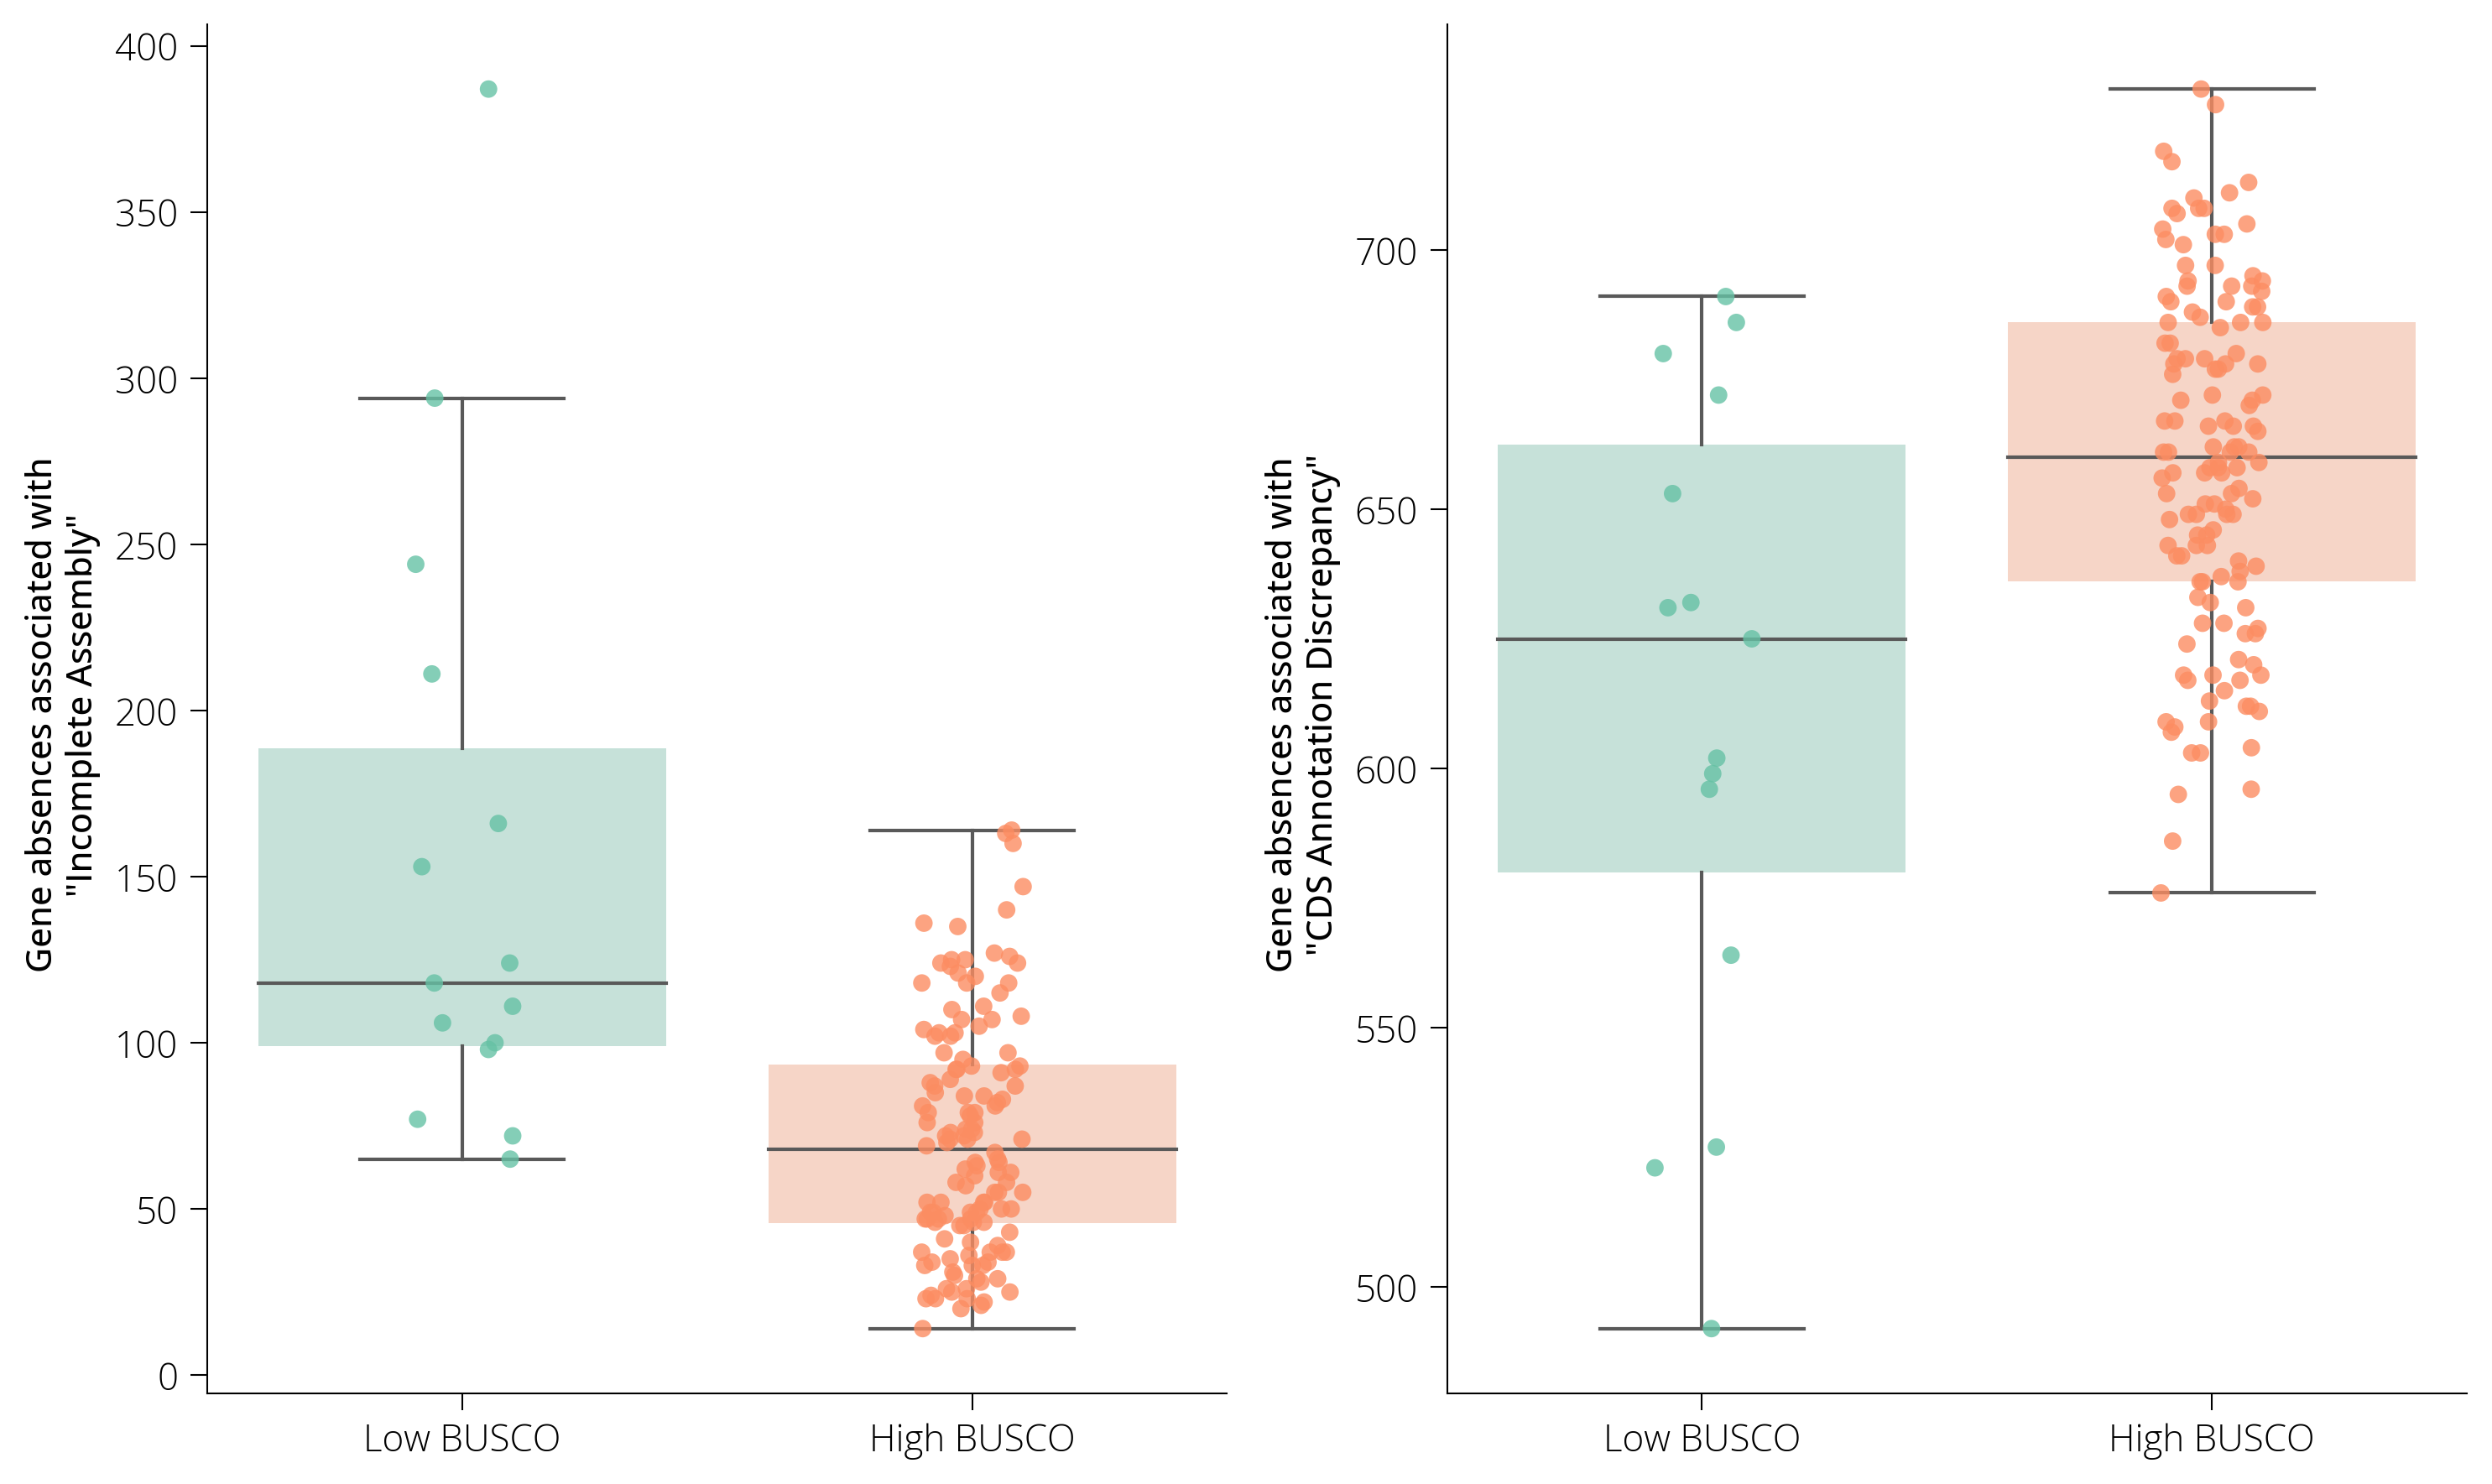

In [82]:
!mkdir Results4_Plots
#sns.set_context("paper", font_scale=1.5)

# Combine the data and label them for plotting
data_IncompAsm = pd.concat([IncompAsm_LoBUSCO_Ct, IncompAsm_HighBUSCO_Ct])
data_AnnoDiscrep = pd.concat([AnnoDiscrep_LoBUSCO_Ct, AnnoDiscrep_HighBUSCO_Ct])

labels = ['Low BUSCO'] * len(AnnoDiscrep_LoBUSCO_Ct) + ['High BUSCO'] * len(AnnoDiscrep_HighBUSCO_Ct)

# Create a DataFrame for plotting
import pandas as pd
df_SRAsmQC = pd.DataFrame({
    'Group': labels,
    'N_IncompAsm': data_IncompAsm,
    'N_AnnoDiscrep': data_AnnoDiscrep,
})

df_SRAsmQC["SRAsm_BUSCO"] = df_SRAsmQC.index.map(SRAsm_BUSCO_Dict).astype(float)

# Create two subplots side by side
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 6))
#fig.suptitle('Comparison of High and Low BUSCO SR Assemblies', fontsize=16, y = 1.05)

# Plot
sns.boxplot(x='Group', y='N_IncompAsm', data=df_SRAsmQC, palette="Set2",
            boxprops=dict(alpha=0.4, linewidth=0),
            fliersize=0, ax=axes[0])
sns.stripplot(x='Group', y='N_IncompAsm', data=df_SRAsmQC, palette="Set2",
              jitter=True, marker='o', alpha=0.8, edgecolor='gray', ax=axes[0])

axes[0].set_ylabel('Gene absences associated with \n "Incomplete Assembly"')
axes[0].set_xlabel('')
sns.despine(ax=axes[0])

sns.boxplot(x='Group', y='N_AnnoDiscrep', data=df_SRAsmQC, palette="Set2",
            boxprops=dict(alpha=0.4, linewidth=0),
            fliersize=0, ax=axes[1])
sns.stripplot(x='Group', y='N_AnnoDiscrep', data=df_SRAsmQC, palette="Set2",
              jitter=True, marker='o', alpha=0.8, edgecolor='gray', ax=axes[1])

axes[1].set_ylabel('Gene absences associated with \n "CDS Annotation Discrepancy"')
axes[1].set_xlabel('')
sns.despine(ax=axes[1])

# Remove grid lines
axes[0].grid(False)
axes[1].grid(False)
# Adjust layout to prevent overlap
plt.tight_layout()

plt.savefig("Results4_Plots/HighVsLowBUSCO.AbsentGenesAssocBarplots.png", dpi = 300, bbox_inches="tight")
plt.savefig("Results4_Plots/HighVsLowBUSCO.AbsentGenesAssocBarplots.svg", bbox_inches="tight")
plt.show()

In [78]:
df_SRAsmQC

,Group,N_IncompAsm,N_AnnoDiscrep,SRAsm_BUSCO
TB1612,Low BUSCO,71,281,98.0
TB2981,Low BUSCO,63,285,97.5
02_R1896,Low BUSCO,112,278,96.1
TB3334,Low BUSCO,54,277,97.9
N1176,Low BUSCO,77,256,97.9
...,...,...,...,...
S0089-01,High BUSCO,27,286,99.6
S0256-08,High BUSCO,18,299,99.6
S0123-01,High BUSCO,23,295,99.6
S0106-01,High BUSCO,26,305,99.6


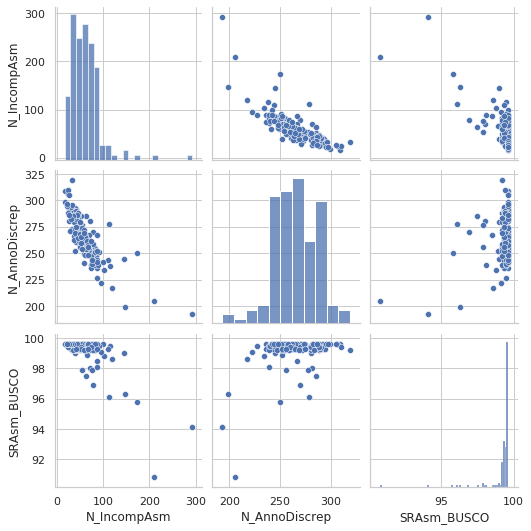

In [79]:
sns.set(style='whitegrid')  # Optional: Set a background style
sns.pairplot(df_SRAsmQC, kind='scatter')
plt.show()

In [80]:
df_SRAsmQC.head(2)

,Group,N_IncompAsm,N_AnnoDiscrep,SRAsm_BUSCO
TB1612,Low BUSCO,71,281,98.0
TB2981,Low BUSCO,63,285,97.5


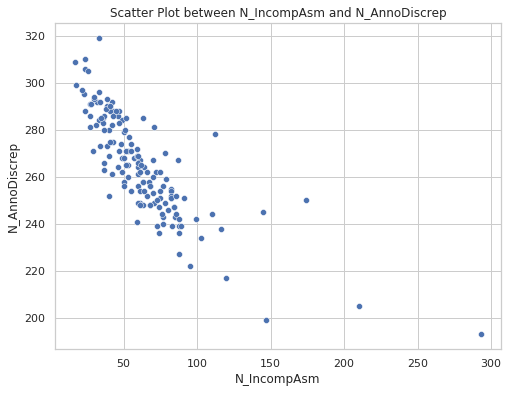

In [81]:
plt.figure(figsize=(8, 6))  # Adjust the figure size as needed
sns.scatterplot(x='N_IncompAsm', y='N_AnnoDiscrep', data=df_SRAsmQC)
plt.title('Scatter Plot between N_IncompAsm and N_AnnoDiscrep')
plt.xlabel('N_IncompAsm')
plt.ylabel('N_AnnoDiscrep')
plt.show()

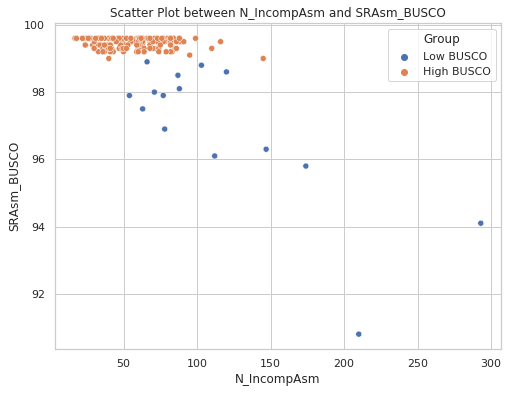

In [82]:

plt.figure(figsize=(8, 6))  # Adjust the figure size as needed
sns.scatterplot(x='N_IncompAsm', y='SRAsm_BUSCO', data=df_SRAsmQC,
                hue = "Group")
plt.title('Scatter Plot between N_IncompAsm and SRAsm_BUSCO')
plt.xlabel('N_IncompAsm')
plt.ylabel('SRAsm_BUSCO')
plt.show()


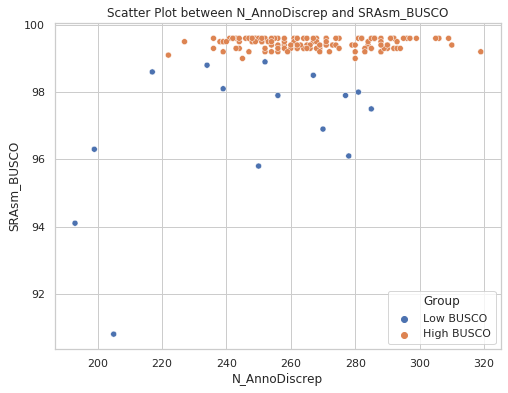

In [83]:

plt.figure(figsize=(8, 6))  # Adjust the figure size as needed
sns.scatterplot(x='N_AnnoDiscrep', y='SRAsm_BUSCO', data=df_SRAsmQC,
                hue = "Group")
plt.title('Scatter Plot between N_AnnoDiscrep and SRAsm_BUSCO')
plt.xlabel('N_AnnoDiscrep')
plt.ylabel('SRAsm_BUSCO')
plt.show()


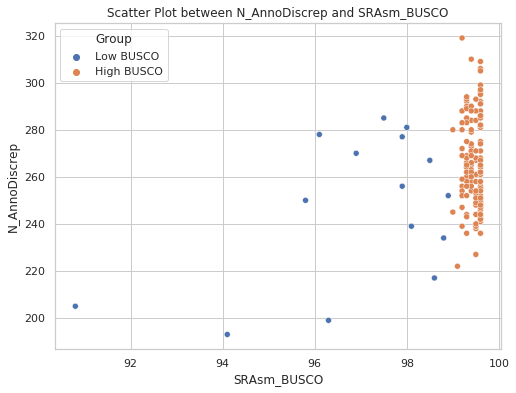

In [87]:

plt.figure(figsize=(8, 6))  # Adjust the figure size as needed
sns.scatterplot(y='N_AnnoDiscrep', x='SRAsm_BUSCO', data=df_SRAsmQC,
                hue = "Group")
plt.title('Scatter Plot between N_AnnoDiscrep and SRAsm_BUSCO')
plt.ylabel('N_AnnoDiscrep')
plt.xlabel('SRAsm_BUSCO')
plt.show()



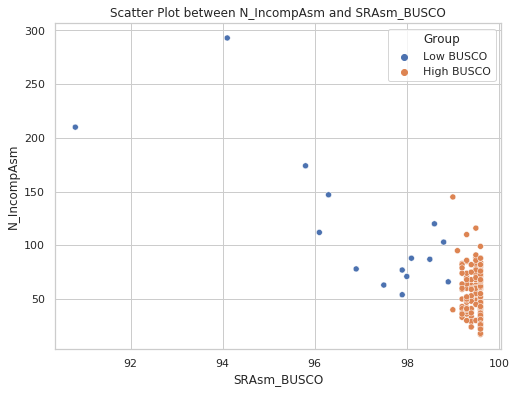

In [86]:

plt.figure(figsize=(8, 6))  # Adjust the figure size as needed
sns.scatterplot(y='N_IncompAsm', x='SRAsm_BUSCO', data=df_SRAsmQC,
                hue = "Group")
plt.title('Scatter Plot between N_IncompAsm and SRAsm_BUSCO')
plt.ylabel('N_IncompAsm')
plt.xlabel('SRAsm_BUSCO')
plt.show()


# Viz heatmap of SRAsm QC wi LR Asm

In [80]:
from matplotlib.colors import ListedColormap

colormap_dict = {0: "#FFFFD6", 1: "#041B4C", 2: "black", 3: "red", 4: "#15ACBB", 5: "#15ACBB"}

# Convert the custom dictionary to a colormap
colors = [colormap_dict[i] for i in sorted(colormap_dict.keys())]
custom_cmap = ListedColormap(colors)


colormap_dict2 = {0: "#FFFFD6", 1: "#041B4C", 2: "#FFFFD6", 3: "#FFFFD6", 4: "#FFFFD6", 5: "#FFFFD6"}

# Convert the custom dictionary to a colormap
colors_2 = [colormap_dict2[i] for i in sorted(colormap_dict2.keys())]
custom_cmap_2 = ListedColormap(colors_2)



In [81]:
sorted(colormap_dict.keys())

[0, 1, 2, 3, 4, 5]

In [82]:
custom_cmap

In [83]:
Pres_LRAsmQC_Dict["SR_Panaroo_Moderate_MP"].head(4)  

,Gene,N0072,N0153,TB3113,TB1236,TB2659,TB2780,TB1612,TB2512,TB2981,TB3091,M0003941_3,TB3368,N0145,N0155,TB2995,TB3396,N0004,N1274,N0054,02_R1179,01_R1134,M0017522_5,M0016395_7,M0010874_7,02_R1708,02_R0894,01_R1430,M0014888_3,02_R1896,TB4620,TB3162,MT_0080,TB3054,TB3251,M0016737_0,TB2661,TB3237,TB3169,TB3386,TB3334,M0011368_9,TB2968,N1272,N1176,N1202,N1177,N0091,RW-TB008,9050-05,4549-04,696-05,702-06,706-05,8129-04,3003-06,8651-04,QC-3,QC-9,QC-5,QC-8,QC-10,QC-4,QC-7,QC-6,QC-1,mada_1-10,mada_2-46,mada_1-1,mada_1-36,mada_1-39,mada_1-51,mada_1-44,mada_117,mada_118,mada_122,mada_107,R27252,R23887,R30215,R30078,R29816,R30234,18_0621851,R36431,R28703,mada_115,mada_2-42,R31095,R28012,R37765,R27657,R25048,R24120,R28581,R29598,mada_1-11,R24100,R21408,R20574,R20260,R18043,R22601,R23146,R32929,R21893,R30420,R26778,R26791,R28980,R27725,R18040,R27937,mada_1-30,mada_2-31,mada_1-41,R21770,R21839,mada_1-32,R30396,R21363,R20896,mada_102,mada_129,mada_139,mada_151,mada_105,R15311,mada_103,mada_2-25,mada_112,mada_124,mada_126,mada_120,R23571,mada_128,mada_1-12,mada_1-15,mada_2-1,mada_1-53,mada_1-50,mada_123,mada_2-53,mada_1-38,S0070-08,S0085-01,S0107-01,S0089-01,S0256-08,S0123-01,S0106-01,S0262-02,NumAsm_WiGene,NumAsm_WiGene_DNASeq,NumAsm_WiGene_AdjByIncompCDSAsm,NumAsm_WiGene_AdjByIncompCDSAsm_And_CDSAnnoDisc
Gene,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
group_2429,group_2429,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,151,151,151,151
rbsK,rbsK,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,151,151,151,151
glfT1,glfT1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,151,151,151,151
fadB3,fadB3,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,151,151,151,151


In [84]:
Pres_LRAsmQC_Dict.keys()

dict_keys(['SR_Panaroo_Strict_MP', 'SR_Panaroo_Moderate_MP', 'SR_Panaroo_Sens_MP', 'SR_Roary_NoSplitParalogs', 'SR_Roary_NoSplitParalogs_I90', 'SR_Roary_NoSplitParalogs_I80'])

## Plot all BEFORE & AFTER LR-Asm QC plots

SR_Panaroo_Strict_MP
(151, 1300)


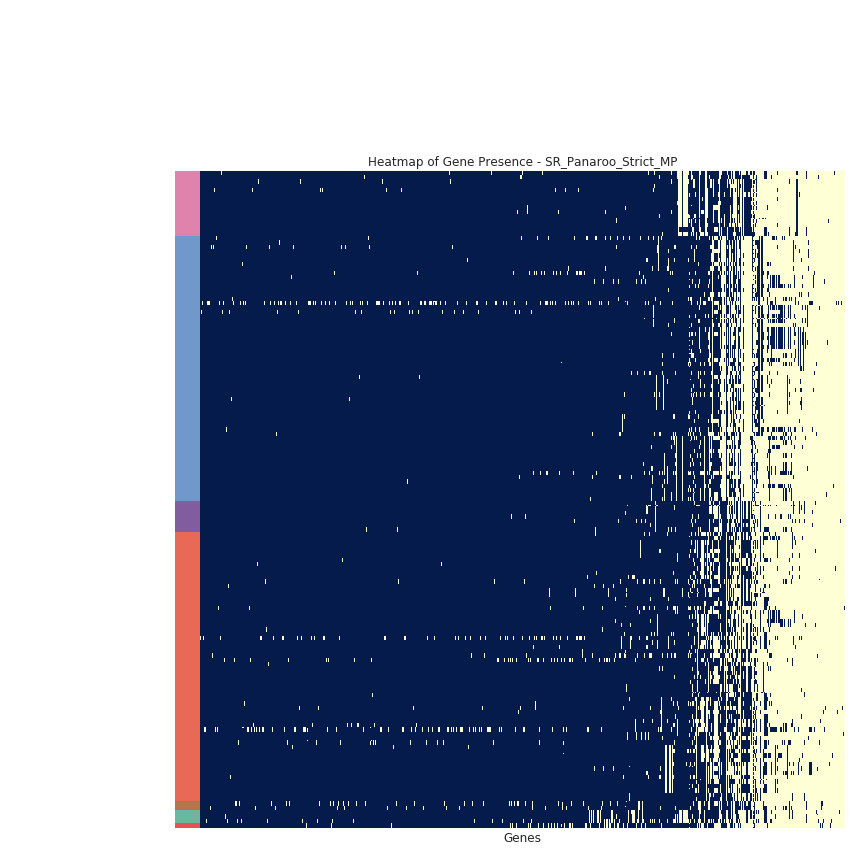

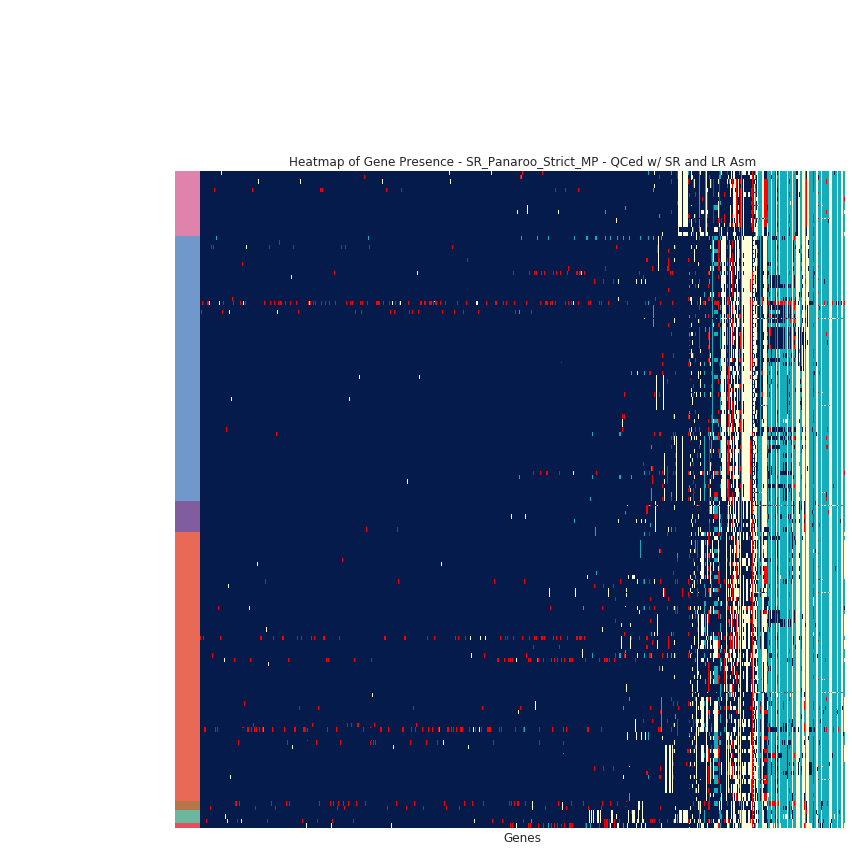

SR_Panaroo_Moderate_MP
(151, 1447)


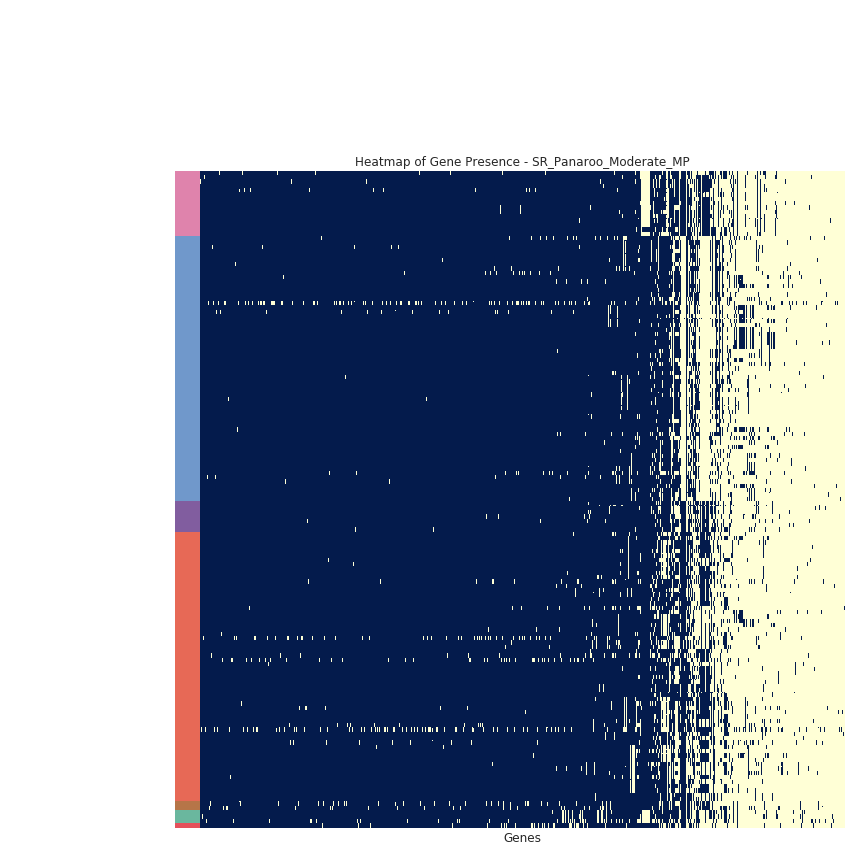

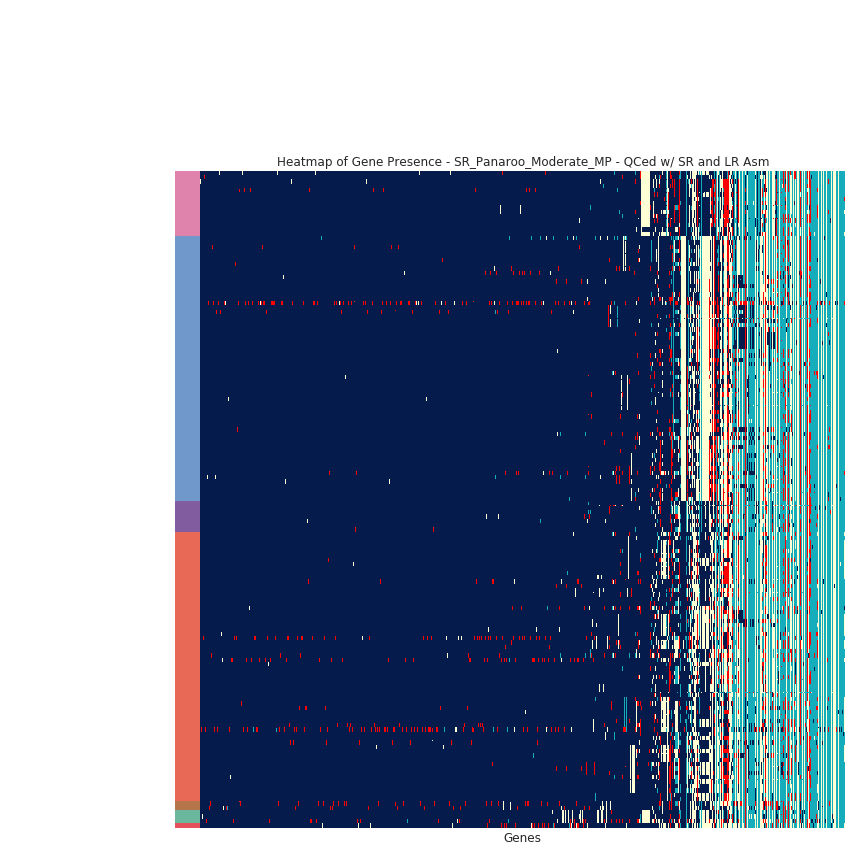

SR_Panaroo_Sens_MP
(151, 1664)


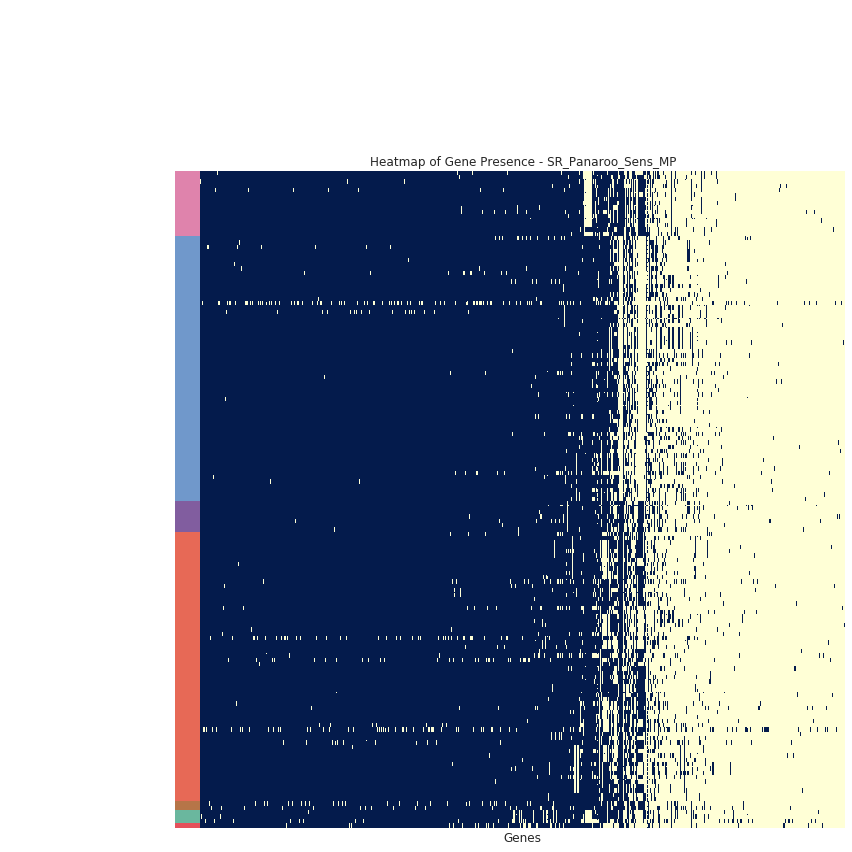

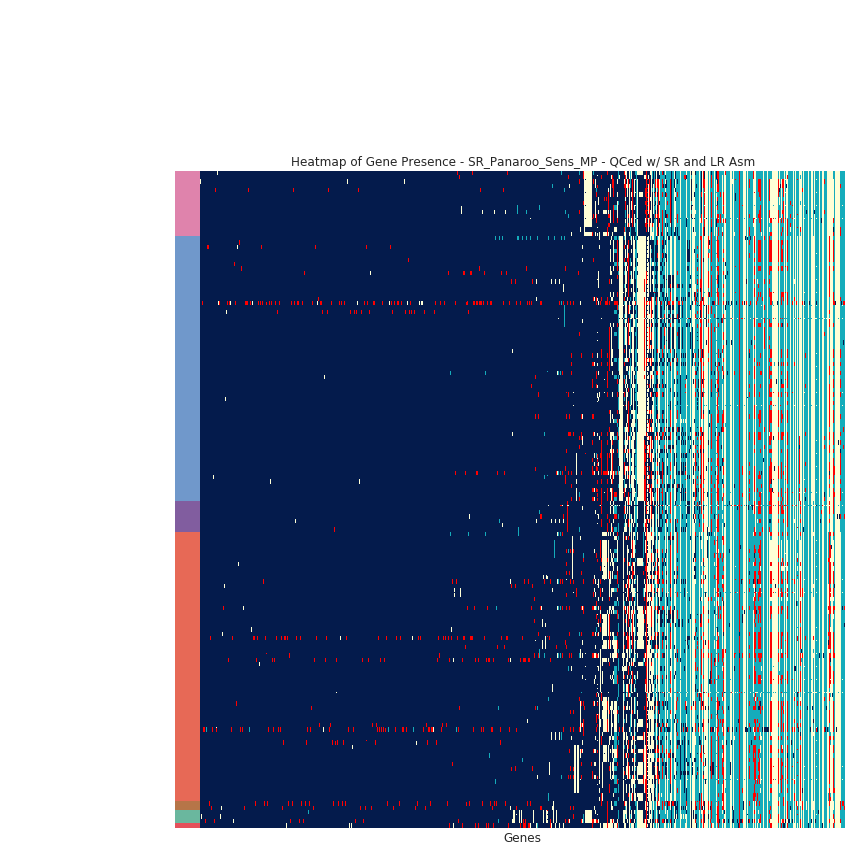

SR_Roary_NoSplitParalogs
(151, 2413)


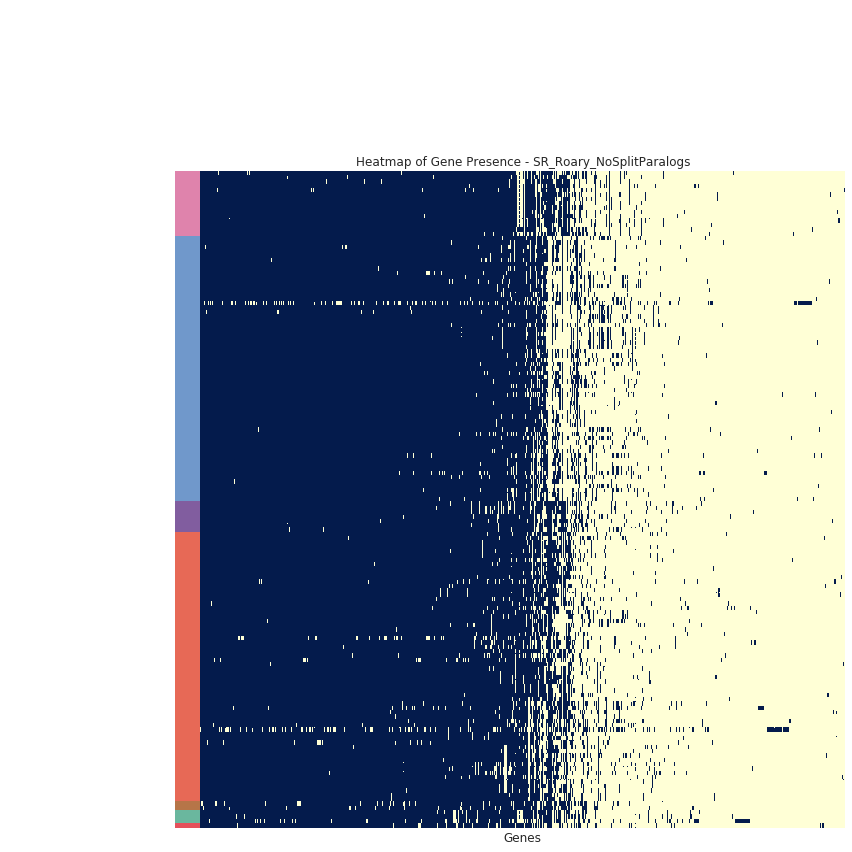

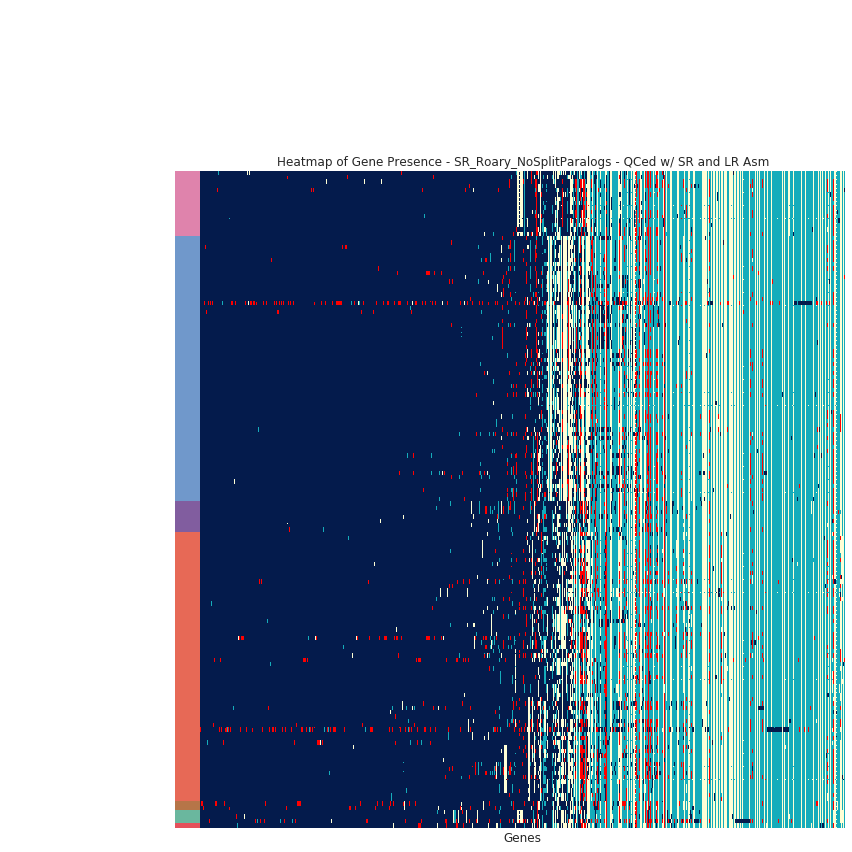

SR_Roary_NoSplitParalogs_I90
(151, 2335)


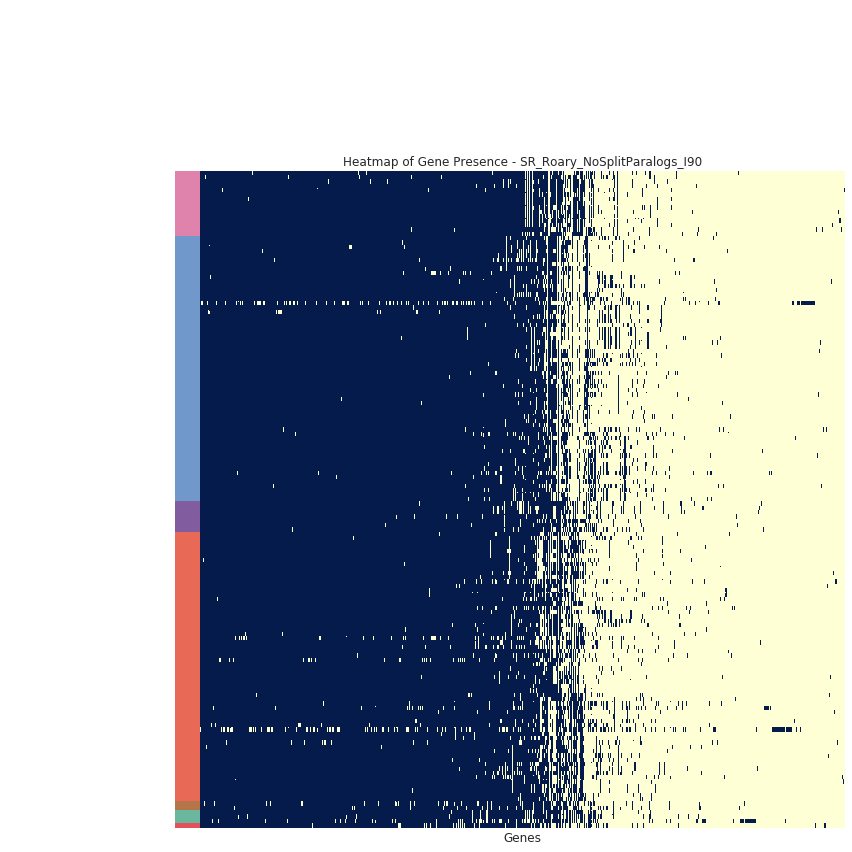

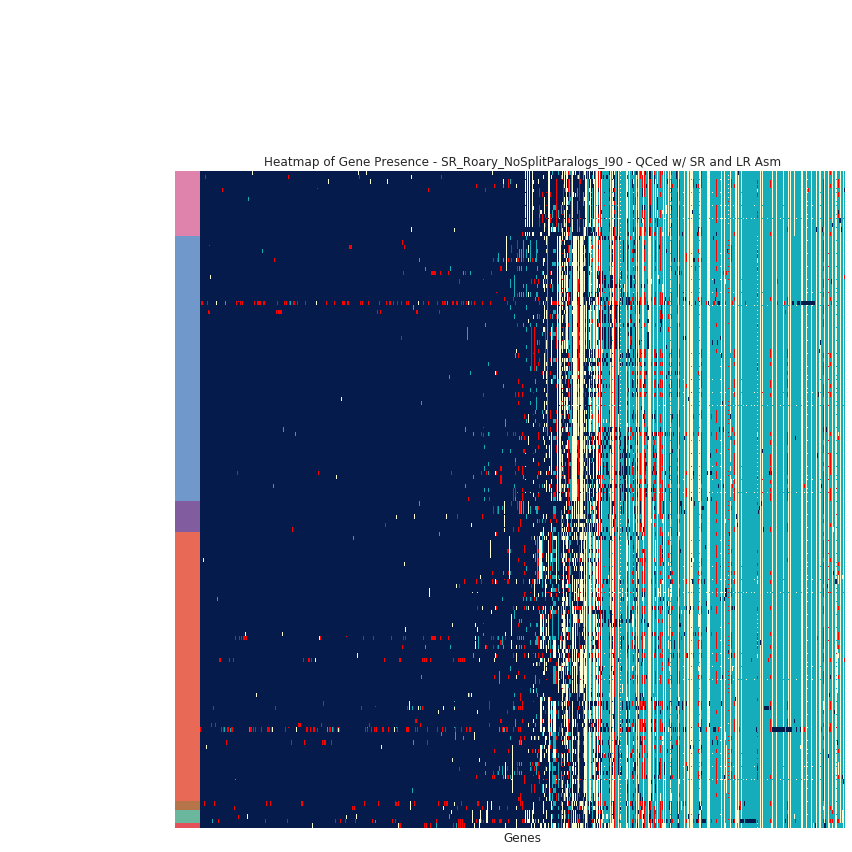

SR_Roary_NoSplitParalogs_I80
(151, 2234)


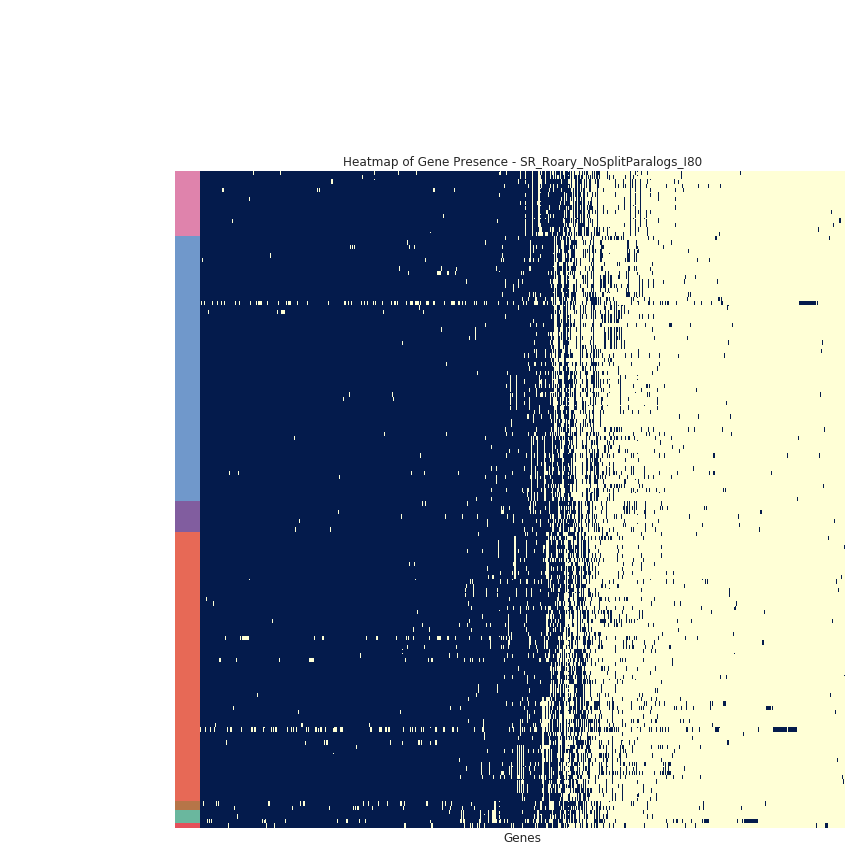

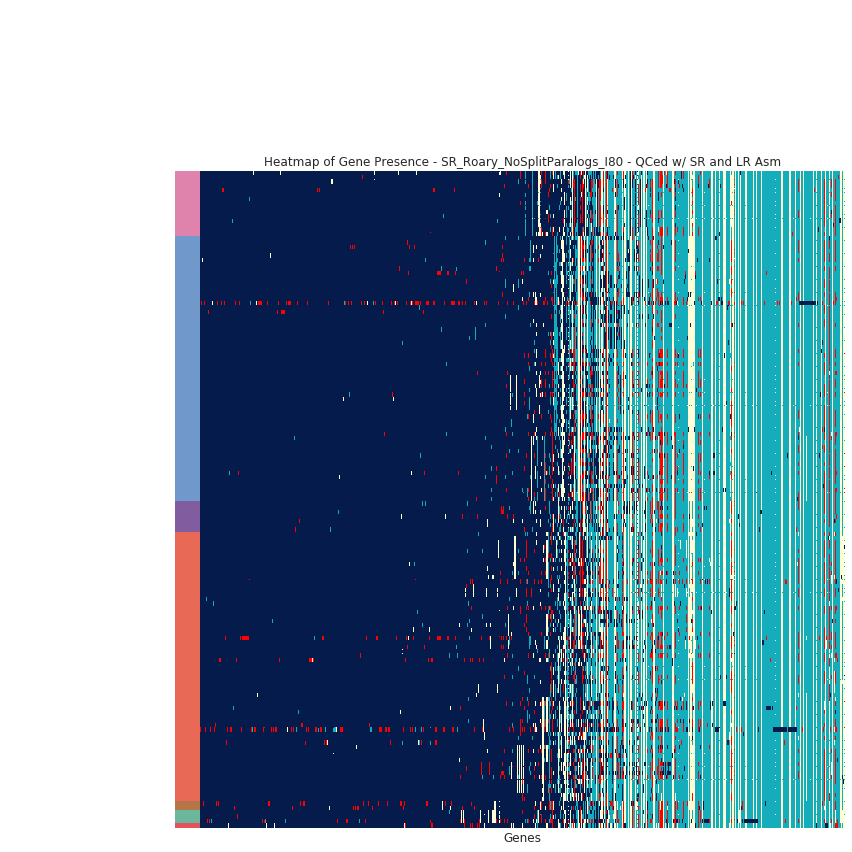

In [85]:
for i_Param in list(Pres_LRAsmQC_Dict.keys()): #['SR_Panaroo_Strict',  'SR_Roary_Default',]: 
                #'SR_Panaroo_Moderate', 'SR_Panaroo_Sens', 'SR_Roary_Default', 'SR_Roary_NoSplitParalogs', 'SR_Roary_NoSplitParalogs_I90']:

    print(i_Param)

    DF = Pres_LRAsmQC_Dict[i_Param].sort_values("NumAsm_WiGene", ascending=False) 

    heatmap_data = DF.query("NumAsm_WiGene <= 150")[OrderOfSampleIDs_Phylo].T
    print(heatmap_data.shape)
    
    row_colors = [sample_colors.get(sample, "black") for sample in heatmap_data.index]
    
    # Plotting the heatmap - BEFORE QC
    
    fig_dims = (12, 12)
    clustermap_plot = sns.clustermap(heatmap_data, 
                                     row_colors=row_colors,
                                     cmap = custom_cmap_2, vmax= 5,
                                     figsize=fig_dims, 
                                     row_cluster=False, col_cluster=False,
                                     cbar_pos = None,
                                     linewidths=0,
                                     xticklabels=False,
                                     yticklabels=False)
    
    #sns.heatmap(heatmap_data, cmap = custom_cmap, cbar=False, xticklabels=False, yticklabels=False, vmax=5)
    plt.title(f'Heatmap of Gene Presence - {i_Param}')
    plt.ylabel('Assemblies')
    plt.ylabel('')
    
    plt.xlabel('Genes')
    plt.show() 

    # Plotting the heatmap - AFTER SR AND LR Asm QC
    
    fig_dims = (12, 12)
    clustermap_plot = sns.clustermap(heatmap_data, 
                                     row_colors=row_colors,
                                     cmap = custom_cmap, vmax= 5,
                                     figsize=fig_dims, 
                                     row_cluster=False, col_cluster=False,
                                     cbar_pos = None,
                                     linewidths=0,
                                     xticklabels=False,
                                     yticklabels=False)
    
    #sns.heatmap(heatmap_data, cmap = custom_cmap, cbar=False, xticklabels=False, yticklabels=False, vmax=5)
    plt.title(f'Heatmap of Gene Presence - {i_Param} - QCed w/ SR and LR Asm')
    plt.ylabel('Assemblies')
    plt.ylabel('')
    
    plt.xlabel('Genes')
    plt.show() 



    
    

In [86]:
Pres_LRAsmQC_Dict["SR_Panaroo_Moderate"].sort_values("NumAsm_WiGene", ascending=False).head(3)

KeyError: 'SR_Panaroo_Moderate'

In [ ]:
DF = Pres_LRAsmQC_Dict["SR_Panaroo_Moderate"].sort_values("NumAsm_WiGene", ascending=False)

In [ ]:
NonSampleID_Cols = ["Gene", "NumAsm_WiGene", "NumAsm_WiGene_DNASeq"]

DF.drop(High_SRBusco_SampleIDs_136CI + NonSampleID_Cols , axis = 1).head(3)

In [ ]:
#DF = Pres_LRAsmQC_Dict["SR_Panaroo_Moderate"].sort_values("NumAsm_WiGene", ascending=False)

#DF_LoBUSCO = DF = 
#DF_LoBUSCO = DF = 


In [ ]:

# Selecting only the columns corresponding to the samples for the heatmap

NonSampleID_Cols = ["Gene", "NumAsm_WiGene", "NumAsm_WiGene_DNASeq"]

DF = Pres_LRAsmQC_Dict["SR_Panaroo_Moderate"].sort_values("NumAsm_WiGene", ascending=False)

heatmap_data = DF.query("NumAsm_WiGene <= 150").drop(High_SRBusco_SampleIDs_136CI + NonSampleID_Cols , axis = 1).T
print(heatmap_data.shape)
row_colors = [sample_colors.get(sample, "black") for sample in heatmap_data.index]
# Plotting the heatmap
fig_dims = (12, 12)
clustermap_plot = sns.clustermap(heatmap_data, row_colors=row_colors,
                                 cmap = custom_cmap, vmax= 5, figsize=fig_dims, 
                                 row_cluster=False, col_cluster=False,
                                 cbar_pos = None, linewidths=0, xticklabels=False, yticklabels=False)

#sns.heatmap(heatmap_data, cmap = custom_cmap, cbar=False, xticklabels=False, yticklabels=False, vmax=5)
plt.title('Presence/Absence Heatmap of Genes Across Assemblies')

plt.xlabel('Genes')
plt.show()   


# Selecting only the columns corresponding to the samples for the heatmap

heatmap_data = DF.query("NumAsm_WiGene <= 150").drop(Low_SRBusco_SampleIDs_15CI + NonSampleID_Cols , axis = 1).T
print(heatmap_data.shape)
row_colors = [sample_colors.get(sample, "black") for sample in heatmap_data.index]
# Plotting the heatmap
fig_dims = (12, 12)
clustermap_plot = sns.clustermap(heatmap_data, row_colors=row_colors,
                                 cmap = custom_cmap, vmax= 5, figsize=fig_dims, 
                                 row_cluster=False, col_cluster=False,
                                 cbar_pos = None, linewidths=0, xticklabels=False, yticklabels=False)

#sns.heatmap(heatmap_data, cmap = custom_cmap, cbar=False, xticklabels=False, yticklabels=False, vmax=5)
plt.title('Presence/Absence Heatmap of Genes Across Assemblies')

plt.xlabel('Genes')
plt.show()   

In [ ]:
for i_Param in list(Pres_LRAsmQC_Dict.keys()): #['SR_Panaroo_Strict',  'SR_Roary_Default',]: 
                #'SR_Panaroo_Moderate', 'SR_Panaroo_Sens', 'SR_Roary_Default', 'SR_Roary_NoSplitParalogs', 'SR_Roary_NoSplitParalogs_I90']:

    print(i_Param)

    DF = Pres_LRAsmQC_Dict[i_Param].sort_values("NumAsm_WiGene", ascending=False) 

    heatmap_data = DF.query("NumAsm_WiGene <= 150")[OrderOfSampleIDs_Phylo].T
    print(heatmap_data.shape)
    
    row_colors = [sample_colors.get(sample, "black") for sample in heatmap_data.index]
    
    # Plotting the heatmap - BEFORE QC
    
    fig_dims = (12, 12)
    clustermap_plot = sns.clustermap(heatmap_data, 
                                     row_colors=row_colors,
                                     cmap = custom_cmap_2, vmax= 5,
                                     figsize=fig_dims, 
                                     row_cluster=False, col_cluster=False,
                                     cbar_pos = None,
                                     linewidths=0,
                                     xticklabels=False,
                                     yticklabels=False)
    
    #sns.heatmap(heatmap_data, cmap = custom_cmap, cbar=False, xticklabels=False, yticklabels=False, vmax=5)
    plt.title(f'Heatmap of Gene Presence - {i_Param}')
    plt.ylabel('Assemblies')
    plt.ylabel('')
    
    plt.xlabel('Genes')
    plt.show() 

    # Plotting the heatmap - AFTER SR AND LR Asm QC
    
    fig_dims = (12, 12)
    clustermap_plot = sns.clustermap(heatmap_data, 
                                     row_colors=row_colors,
                                     cmap = custom_cmap, vmax= 5,
                                     figsize=fig_dims, 
                                     row_cluster=False, col_cluster=False,
                                     cbar_pos = None,
                                     linewidths=0,
                                     xticklabels=False,
                                     yticklabels=False)
    
    #sns.heatmap(heatmap_data, cmap = custom_cmap, cbar=False, xticklabels=False, yticklabels=False, vmax=5)
    plt.title(f'Heatmap of Gene Presence - {i_Param} - QCed w/ SR and LR Asm')
    plt.ylabel('Assemblies')
    plt.ylabel('')
    
    plt.xlabel('Genes')
    plt.show() 



    
    

## Plot all BEFORE & AFTER LR-Asm QC plots - WHOLE Pan-genome Matrix

In [ ]:
for i_Param in list(Pres_LRAsmQC_Dict.keys()): #['SR_Panaroo_Strict',  'SR_Roary_Default',]: 
                #'SR_Panaroo_Moderate', 'SR_Panaroo_Sens', 'SR_Roary_Default', 'SR_Roary_NoSplitParalogs', 'SR_Roary_NoSplitParalogs_I90']:

    print(i_Param)

    DF = Pres_LRAsmQC_Dict[i_Param].sort_values("NumAsm_WiGene", ascending=False)

    #heatmap_data = DF.query("NumAsm_WiGene <= 150")[OrderOfSampleIDs_Phylo].T
    heatmap_data = DF[OrderOfSampleIDs_Phylo].T

    print(heatmap_data.shape)
    
    row_colors = [sample_colors.get(sample, "black") for sample in heatmap_data.index]
    
    # Plotting the heatmap - BEFORE QC
    
    fig_dims = (12, 12)
    clustermap_plot = sns.clustermap(heatmap_data, 
                                     row_colors=row_colors,
                                     cmap = custom_cmap_2, vmax= 5,
                                     figsize=fig_dims, 
                                     row_cluster=False, col_cluster=False,
                                     cbar_pos = None,
                                     linewidths=0,
                                     xticklabels=False,
                                     yticklabels=False)
    
    #sns.heatmap(heatmap_data, cmap = custom_cmap, cbar=False, xticklabels=False, yticklabels=False, vmax=5)
    plt.title(f'Heatmap of Gene Presence - {i_Param}')
    plt.ylabel('Assemblies')
    plt.ylabel('')
    
    plt.xlabel('Genes')
    plt.show() 

    # Plotting the heatmap - AFTER SR AND LR Asm QC
    
    fig_dims = (12, 12)
    clustermap_plot = sns.clustermap(heatmap_data, 
                                     row_colors=row_colors,
                                     cmap = custom_cmap, vmax= 5,
                                     figsize=fig_dims, 
                                     row_cluster=False, col_cluster=False,
                                     cbar_pos = None,
                                     linewidths=0,
                                     xticklabels=False,
                                     yticklabels=False)
    
    #sns.heatmap(heatmap_data, cmap = custom_cmap, cbar=False, xticklabels=False, yticklabels=False, vmax=5)
    plt.title(f'Heatmap of Gene Presence - {i_Param} - QCed w/ SR and LR Asm')
    plt.ylabel('Assemblies')
    plt.ylabel('')
    
    plt.xlabel('Genes')
    plt.show() 



    
    

In [ ]:
# Selecting only the columns corresponding to the samples for the heatmap

DF = Pres_LRAsmQC_Dict["SR_Panaroo_Moderate"].sort_values("NumAsm_WiGene", ascending=False)


heatmap_data = DF.query("NumAsm_WiGene <= 150")[OrderOfSampleIDs_Phylo].T
print(heatmap_data.shape)

row_colors = [sample_colors.get(sample, "black") for sample in heatmap_data.index]

# Plotting the heatmap

fig_dims = (12, 12)
clustermap_plot = sns.clustermap(heatmap_data, 
                                 row_colors=row_colors,
                                 cmap = custom_cmap_2, vmax= 5,
                                 figsize=fig_dims, 
                                 row_cluster=False, col_cluster=False,
                                 cbar_pos = None,
                                 linewidths=0,
                                 xticklabels=False,
                                 yticklabels=False)

#sns.heatmap(heatmap_data, cmap = custom_cmap, cbar=False, xticklabels=False, yticklabels=False, vmax=5)
plt.title('Presence/Absence Heatmap of Genes Across Assemblies')
plt.ylabel('Assemblies')
plt.ylabel('')

plt.xlabel('Genes')
plt.show()   

In [ ]:
# Selecting only the columns corresponding to the samples for the heatmap

DF = Pres_LRAsmQC_Dict["SR_Panaroo_Moderate"].sort_values("NumAsm_WiGene", ascending=False)
#DF = PresAbs_DF_LRAsmSeqChk_Dict["SR_Panaroo_Strict"] #.sort_values("NumAsm_WiGene", ascending=False)


heatmap_data = DF.query("NumAsm_WiGene <= 150")[OrderOfSampleIDs_Phylo].T
print(heatmap_data.shape)

row_colors = [sample_colors.get(sample, "black") for sample in heatmap_data.index]

# Plotting the heatmap

fig_dims = (12, 12)
clustermap_plot = sns.clustermap(heatmap_data, 
                                 row_colors=row_colors,
                                 cmap = custom_cmap, vmax= 5,
                                 figsize=fig_dims, 
                                 row_cluster=False, col_cluster=False,
                                 cbar_pos = None,
                                 linewidths=0,
                                 xticklabels=False,
                                 yticklabels=False)

#sns.heatmap(heatmap_data, cmap = custom_cmap, cbar=False, xticklabels=False, yticklabels=False, vmax=5)
plt.title('Presence/Absence Heatmap of Genes Across Assemblies')
plt.ylabel('Assemblies')
plt.ylabel('')

plt.xlabel('Genes')
plt.show() 

In [ ]:
# Selecting only the columns corresponding to the samples for the heatmap

DF = Pres_LRAsmQC_Dict["SR_Panaroo_Moderate"].sort_values("NumAsm_WiGene_DNASeq", ascending=False)


heatmap_data = DF.query("NumAsm_WiGene <= 150")[OrderOfSampleIDs_Phylo].T

row_colors = [sample_colors.get(sample, "black") for sample in heatmap_data.index]

# Plotting the heatmap

fig_dims = (12, 12)
clustermap_plot = sns.clustermap(heatmap_data, 
                                 row_colors=row_colors,
                                 cmap = custom_cmap, vmax= 5,
                                 figsize=fig_dims, 
                                 row_cluster=False, col_cluster=False,
                                 cbar_pos = None,
                                 linewidths=0,
                                 xticklabels=False,
                                 yticklabels=False)

#sns.heatmap(heatmap_data, cmap = custom_cmap, cbar=False, xticklabels=False, yticklabels=False, vmax=5)
plt.title('Presence/Absence Heatmap of Genes Across Assemblies')
plt.ylabel('Assemblies')
plt.ylabel('')

plt.xlabel('Genes')
plt.show()   

### SR - Roary Default

In [ ]:
# Selecting only the columns corresponding to the samples for the heatmap

DF = Pres_LRAsmQC_Dict["SR_Roary_Default"].sort_values("NumAsm_WiGene", ascending=False)


heatmap_data = DF.query("NumAsm_WiGene <= 150")[OrderOfSampleIDs_Phylo].T
print(heatmap_data.shape)

row_colors = [sample_colors.get(sample, "black") for sample in heatmap_data.index]

# Plotting the heatmap

fig_dims = (12, 12)
clustermap_plot = sns.clustermap(heatmap_data, 
                                 row_colors=row_colors,
                                 cmap = custom_cmap_2, vmax= 5,
                                 figsize=fig_dims, 
                                 row_cluster=False, col_cluster=False,
                                 cbar_pos = None,
                                 linewidths=0,
                                 xticklabels=False,
                                 yticklabels=False)

#sns.heatmap(heatmap_data, cmap = custom_cmap, cbar=False, xticklabels=False, yticklabels=False, vmax=5)
plt.title('Presence/Absence Heatmap of Genes Across Assemblies')
plt.ylabel('Assemblies')
plt.ylabel('')

plt.xlabel('Genes')
plt.show()   

In [ ]:
# Selecting only the columns corresponding to the samples for the heatmap

DF = Pres_LRAsmQC_Dict["SR_Roary_Default"].sort_values("NumAsm_WiGene", ascending=False)
#DF = PresAbs_DF_LRAsmSeqChk_Dict["SR_Panaroo_Strict"] #.sort_values("NumAsm_WiGene", ascending=False)


heatmap_data = DF.query("NumAsm_WiGene <= 150")[OrderOfSampleIDs_Phylo].T
print(heatmap_data.shape)

row_colors = [sample_colors.get(sample, "black") for sample in heatmap_data.index]

# Plotting the heatmap

fig_dims = (12, 12)
clustermap_plot = sns.clustermap(heatmap_data, 
                                 row_colors=row_colors,
                                 cmap = custom_cmap, vmax= 5,
                                 figsize=fig_dims, 
                                 row_cluster=False, col_cluster=False,
                                 cbar_pos = None,
                                 linewidths=0,
                                 xticklabels=False,
                                 yticklabels=False)

#sns.heatmap(heatmap_data, cmap = custom_cmap, cbar=False, xticklabels=False, yticklabels=False, vmax=5)
plt.title('Presence/Absence Heatmap of Genes Across Assemblies')
plt.ylabel('Assemblies')
plt.ylabel('')

plt.xlabel('Genes')
plt.show() 

In [ ]:
# Selecting only the columns corresponding to the samples for the heatmap

DF = Pres_LRAsmQC_Dict["SR_Roary_Default"].sort_values(["NumAsm_WiGene_DNASeq", "NumAsm_WiGene"], ascending=False)


heatmap_data = DF.query("NumAsm_WiGene <= 150")[OrderOfSampleIDs_Phylo].T

row_colors = [sample_colors.get(sample, "black") for sample in heatmap_data.index]

# Plotting the heatmap

fig_dims = (12, 12)
clustermap_plot = sns.clustermap(heatmap_data, 
                                 row_colors=row_colors,
                                 cmap = custom_cmap, vmax= 5,
                                 figsize=fig_dims, 
                                 row_cluster=False, col_cluster=False,
                                 cbar_pos = None,
                                 linewidths=0,
                                 xticklabels=False,
                                 yticklabels=False)

#sns.heatmap(heatmap_data, cmap = custom_cmap, cbar=False, xticklabels=False, yticklabels=False, vmax=5)
plt.title('Presence/Absence Heatmap of Genes Across Assemblies')
plt.ylabel('Assemblies')
plt.ylabel('')

plt.xlabel('Genes')
plt.show()   

In [ ]:
STOP!!!!

## Extra - Exploration of PG numbers before and after `AsmGeneSeqSearch` step

In [ ]:
listOfRows = []

for i_Param, _ in PG_PresAbs_AsmGeneSeqChk_PATH_Dict.items():
    print(i_Param)

    N_Total, N_Core, N_Acc = get_PG_Stats_FromPresAbs(PresAbs_DF_AsmSeqChk_Dict[i_Param], 20)

    i_row = (i_Param, "Original", N_Total, N_Core, N_Acc)
    listOfRows.append(i_row)

    N_Total, N_Core, N_Acc = get_PG_Stats_FromDNASeqPresAbs(PresAbs_DF_AsmSeqChk_Dict[i_Param], 20)

    i_row = (i_Param, "AdjustBy_DNASeq", N_Total, N_Core, N_Acc)
    listOfRows.append(i_row)

    N_Total, N_Core, N_Acc = get_PG_Stats_FromPresAbs(PresAbs_NSC_Dict[i_Param], 20)

    i_row = (i_Param, "AdjustBy_NSCluster", N_Total, N_Core, N_Acc)
    listOfRows.append(i_row)
    N_Total, N_Core, N_Acc = get_PG_Stats_FromPresAbs(PresAbs_AsmSeqCheck_And_NSC_Dict[i_Param], 20)

    i_row = (i_Param, "AdjustByDNASeq_And_NSCluster", N_Total, N_Core, N_Acc)
    listOfRows.append(i_row)


    
    print("-"*20, "\n")


PG_Summ_DF = pd.DataFrame(listOfRows)

PG_Summ_DF.columns = ["Param", "Approach", "Total", "Core", "Accessory"]



In [ ]:
STOP!

# Viz differences between CDS Pres and GeneSeq Pres matrix

In [ ]:

from matplotlib.colors import ListedColormap, BoundaryNorm

# Custom colormap
colors = ["#FFFFD6", "#041B4C", "#15ACBB"] 
cmap_name = "custom_div_cmap"
#cm_1 = LinearSegmentedColormap.from_list(cmap_name, colors, N=3)
cm_1 = ListedColormap(colors)

# Custom colormap
colors_2 = ["#FFFFD6", "#041B4C", "#15ACBB", "red", "purple"] 
cmap_name_2 = "custom_div_cmap_2"
cm_2 = ListedColormap(colors_2)



### LR - Panaroo Moderate Merge Paralogs

In [ ]:
# Selecting only the columns corresponding to the samples for the heatmap
heatmap_data = PresAbs_DF_Dict["Panaroo_Moderate"].query("NumAsm_WiGene <= 150")[ListOf_SampleID_Cols].T

# Plotting the heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(heatmap_data, cmap = cm_1, cbar=False, xticklabels=False, yticklabels=False, vmax=2)
plt.title('Presence/Absence Heatmap of Genes Across Assemblies')
plt.ylabel('Assemblies')
plt.ylabel('')

plt.xlabel('Genes')
plt.show()


In [ ]:
# Selecting only the columns corresponding to the samples for the heatmap
heatmap_data = PresAbs_DF_AsmSeqChk_Dict["Panaroo_Moderate"].query("NumAsm_WiGene <= 150")[ListOf_SampleID_Cols].T

# Plotting the heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(heatmap_data, cmap = cm_1, cbar=False, xticklabels=False, yticklabels=False, vmax=2)
plt.title('Presence/Absence Heatmap of Genes Across Assemblies')
plt.ylabel('Assemblies')
plt.ylabel('')

plt.xlabel('Genes')
plt.show()

In [ ]:
# Selecting only the columns corresponding to the samples for the heatmap

DF = PresAbs_DF_AsmSeqChk_Dict["Panaroo_Moderate"].sort_values("NumAsm_WiGene_DNASeq", ascending=False)

heatmap_data = DF.query("NumAsm_WiGene <= 150")[ListOf_SampleID_Cols].T

# Plotting the heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(heatmap_data, cmap = cm_1, cbar=False, xticklabels=False, yticklabels=False, vmax=2)
plt.title('Presence/Absence Heatmap of Genes Across Assemblies')
plt.ylabel('Assemblies')
plt.ylabel('')

plt.xlabel('Genes')
plt.show()

### LR - Panaroo Moderate Merge Paralogs

In [ ]:
# Selecting only the columns corresponding to the samples for the heatmap
heatmap_data = PresAbs_DF_Dict["Panaroo_Moderate"].query("NumAsm_WiGene <= 150")[ListOf_SampleID_Cols].T

# Plotting the heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(heatmap_data, cmap = cm_1, cbar=False, xticklabels=False, yticklabels=False, vmax=2)
plt.title('Presence/Absence Heatmap of Genes Across Assemblies')
plt.ylabel('Assemblies')
plt.ylabel('')

plt.xlabel('Genes')
plt.show()


In [ ]:
# Selecting only the columns corresponding to the samples for the heatmap
heatmap_data = PresAbs_DF_AsmSeqChk_Dict["Panaroo_Moderate"].query("NumAsm_WiGene <= 150")[ListOf_SampleID_Cols].T

# Plotting the heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(heatmap_data, cmap = cm_1, cbar=False, xticklabels=False, yticklabels=False, vmax=2)
plt.title('Presence/Absence Heatmap of Genes Across Assemblies')
plt.ylabel('Assemblies')
plt.ylabel('')

plt.xlabel('Genes')
plt.show()

In [ ]:
# Selecting only the columns corresponding to the samples for the heatmap

DF = PresAbs_DF_AsmSeqChk_Dict["Panaroo_Moderate"].sort_values("NumAsm_WiGene_DNASeq", ascending=False)

heatmap_data = DF.query("NumAsm_WiGene <= 150")[ListOf_SampleID_Cols].T

# Plotting the heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(heatmap_data, cmap = cm_1, cbar=False, xticklabels=False, yticklabels=False, vmax=2)
plt.title('Presence/Absence Heatmap of Genes Across Assemblies')
plt.ylabel('Assemblies')
plt.ylabel('')

plt.xlabel('Genes')
plt.show()

In [ ]:
# Selecting only the columns corresponding to the samples for the heatmap

DF = PresAbs_DF_Dict["SR_Panaroo_Moderate_MP"]
heatmap_data = DF.query("NumAsm_WiGene <= 150")[ListOf_SampleID_Cols].T

# Plotting the heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(heatmap_data, cmap = cm_1, cbar=False, xticklabels=False, yticklabels=False, vmax=2)
plt.title('Presence/Absence Heatmap of Genes Across Assemblies')
plt.ylabel('Assemblies')
plt.ylabel('')

plt.xlabel('Genes')
plt.show()


In [ ]:
# Selecting only the columns corresponding to the samples for the heatmap
DF = PresAbs_DF_AsmSeqChk_Dict["SR_Panaroo_Moderate_MP"]  
heatmap_data = DF.query("NumAsm_WiGene <= 150")[ListOf_SampleID_Cols].T

# Plotting the heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(heatmap_data, cmap = cm_1, cbar=False, xticklabels=False, yticklabels=False, vmax=2)
plt.title('Presence/Absence Heatmap of Genes Across Assemblies')
plt.ylabel('Assemblies')
plt.ylabel('')

plt.xlabel('Genes')
plt.show()

In [ ]:
# Selecting only the columns corresponding to the samples for the heatmap

DF = PresAbs_DF_AsmSeqChk_Dict["SR_Panaroo_Moderate_MP"].sort_values("NumAsm_WiGene_DNASeq", ascending=False)

heatmap_data = DF.query("NumAsm_WiGene <= 150")[ListOf_SampleID_Cols].T

# Plotting the heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(heatmap_data, cmap = cm_1, cbar=False, xticklabels=False, yticklabels=False, vmax=2)
plt.title('Presence/Absence Heatmap of Genes Across Assemblies')
plt.ylabel('Assemblies')
plt.ylabel('')

plt.xlabel('Genes')
plt.show()   

In [ ]:
# Selecting only the columns corresponding to the samples for the heatmap

DF = PresAbs_DF_AsmSeqChk_Dict["SR_Panaroo_Moderate_MP"].sort_values("NumAsm_WiGene_DNASeq", ascending=False)

heatmap_data = DF.query("NumAsm_WiGene_DNASeq <= 150")[ListOf_SampleID_Cols].T

# Plotting the heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(heatmap_data, cmap = cm_1, cbar=False, xticklabels=False, yticklabels=False, vmax=2)
plt.title('Presence/Absence Heatmap of Genes Across Assemblies')
plt.ylabel('Assemblies')
plt.ylabel('')

plt.xlabel('Genes')
plt.show()   

In [ ]:
PresAbs_DF_LRAsmSeqChk_Dict = PresAbs_DF_SRPG_QC_WiLRAsmSeqChk_Dict

In [ ]:
PresAbs_DF_Dict["SR_Panaroo_Moderate_MP"].shape

In [ ]:
PresAbs_DF_LRAsmSeqChk_Dict["SR_Panaroo_Moderate_MP"].shape

In [ ]:
get_PG_Stats_FromPresAbs(PresAbs_DF_Dict["SR_Panaroo_Moderate_MP"], 158)

In [ ]:
get_PG_Stats_FromPresAbs(PresAbs_DF_Dict["SR_Panaroo_Strict_MP"], 158)

In [ ]:
get_PG_Stats_FromPresAbs(PresAbs_DF_Dict["SR_Panaroo_Moderate_MP"], 158)   

In [ ]:
get_PG_Stats_FromPresAbs(PresAbs_DF_AsmSeqChk_Dict["SR_Panaroo_Moderate_MP"], 158)

In [ ]:
get_PG_Stats_FromDNASeqPresAbs(PresAbs_DF_AsmSeqChk_Dict["SR_Panaroo_Moderate_MP"], 158)

In [ ]:
get_PG_Stats_FromDNASeqPresAbs(PresAbs_DF_LRAsmSeqChk_Dict["SR_Panaroo_Strict_MP"], 158)

In [ ]:
813 - 670

In [ ]:
get_PG_Stats_FromPresAbs(PresAbs_DF_LRAsmSeqChk_Dict["SR_Panaroo_Moderate"], 158)

In [ ]:
get_PG_Stats_FromDNASeqPresAbs(PresAbs_DF_LRAsmSeqChk_Dict["SR_Panaroo_Moderate"], 158)


# Viz heatmap of SRAsm QC wi LR Asm

In [ ]:
from matplotlib.colors import ListedColormap

colormap_dict = {0: "#FFFFD6", 1: "#041B4C", 2: "black", 3: "red", 4: "#15ACBB", 5: "#15ACBB"}

# Convert the custom dictionary to a colormap
colors = [colormap_dict[i] for i in sorted(colormap_dict.keys())]
custom_cmap = ListedColormap(colors)


colormap_dict2 = {0: "#FFFFD6", 1: "#041B4C", 2: "#FFFFD6", 3: "#FFFFD6", 4: "#FFFFD6", 5: "#FFFFD6"}

# Convert the custom dictionary to a colormap
colors_2 = [colormap_dict2[i] for i in sorted(colormap_dict2.keys())]
custom_cmap_2 = ListedColormap(colors_2)



In [ ]:
sorted(colormap_dict.keys())

In [ ]:
custom_cmap

In [ ]:
PresAbs_DF_LRAsmSeqChk_Dict["SR_Panaroo_Moderate"].head(4)

In [ ]:
# Selecting only the columns corresponding to the samples for the heatmap

DF = PresAbs_DF_LRAsmSeqChk_Dict["SR_Panaroo_Moderate_MP"].sort_values("NumAsm_WiGene", ascending=False)


heatmap_data = DF.query("NumAsm_WiGene <= 150")[OrderOfSampleIDs_Phylo].T
print(heatmap_data.shape)

row_colors = [sample_colors.get(sample, "black") for sample in heatmap_data.index]

# Plotting the heatmap

fig_dims = (12, 12)
clustermap_plot = sns.clustermap(heatmap_data, 
                                 row_colors=row_colors,
                                 cmap = custom_cmap_2, vmax= 5,
                                 figsize=fig_dims, 
                                 row_cluster=False, col_cluster=False,
                                 cbar_pos = None,
                                 linewidths=0,
                                 xticklabels=False,
                                 yticklabels=False)

#sns.heatmap(heatmap_data, cmap = custom_cmap, cbar=False, xticklabels=False, yticklabels=False, vmax=5)
plt.title('Presence/Absence Heatmap of Genes Across Assemblies')
plt.ylabel('Assemblies')
plt.ylabel('')

plt.xlabel('Genes')
plt.show()   

In [ ]:
# Selecting only the columns corresponding to the samples for the heatmap

DF = PresAbs_DF_LRAsmSeqChk_Dict["SR_Panaroo_Moderate"].sort_values("NumAsm_WiGene", ascending=False)
#DF = PresAbs_DF_LRAsmSeqChk_Dict["SR_Panaroo_Strict"] #.sort_values("NumAsm_WiGene", ascending=False)


heatmap_data = DF.query("NumAsm_WiGene <= 150")[OrderOfSampleIDs_Phylo].T
print(heatmap_data.shape)

row_colors = [sample_colors.get(sample, "black") for sample in heatmap_data.index]

# Plotting the heatmap

fig_dims = (12, 12)
clustermap_plot = sns.clustermap(heatmap_data, 
                                 row_colors=row_colors,
                                 cmap = custom_cmap, vmax= 5,
                                 figsize=fig_dims, 
                                 row_cluster=False, col_cluster=False,
                                 cbar_pos = None,
                                 linewidths=0,
                                 xticklabels=False,
                                 yticklabels=False)

#sns.heatmap(heatmap_data, cmap = custom_cmap, cbar=False, xticklabels=False, yticklabels=False, vmax=5)
plt.title('Presence/Absence Heatmap of Genes Across Assemblies')
plt.ylabel('Assemblies')
plt.ylabel('')

plt.xlabel('Genes')
plt.show() 

In [ ]:
# Selecting only the columns corresponding to the samples for the heatmap

DF = PresAbs_DF_LRAsmSeqChk_Dict["SR_Panaroo_Moderate"].sort_values("NumAsm_WiGene_DNASeq", ascending=False)


heatmap_data = DF.query("NumAsm_WiGene <= 150")[OrderOfSampleIDs_Phylo].T

row_colors = [sample_colors.get(sample, "black") for sample in heatmap_data.index]

# Plotting the heatmap

fig_dims = (12, 12)
clustermap_plot = sns.clustermap(heatmap_data, 
                                 row_colors=row_colors,
                                 cmap = custom_cmap, vmax= 5,
                                 figsize=fig_dims, 
                                 row_cluster=False, col_cluster=False,
                                 cbar_pos = None,
                                 linewidths=0,
                                 xticklabels=False,
                                 yticklabels=False)

#sns.heatmap(heatmap_data, cmap = custom_cmap, cbar=False, xticklabels=False, yticklabels=False, vmax=5)
plt.title('Presence/Absence Heatmap of Genes Across Assemblies')
plt.ylabel('Assemblies')
plt.ylabel('')

plt.xlabel('Genes')
plt.show()   

In [ ]:
# Selecting only the columns corresponding to the samples for the heatmap

DF = PresAbs_DF_LRAsmSeqChk_Dict["SR_Panaroo_Moderate"].sort_values("NumAsm_WiGene", ascending=False)


heatmap_data = DF.query("NumAsm_WiGene <= 150")[OrderOfSampleIDs_Phylo].T.drop(Low_SRBusco_SampleIDs_15CI, axis = 0)



row_colors = [sample_colors.get(sample, "black") for sample in heatmap_data.index]

# Plotting the heatmap

fig_dims = (12, 12)
clustermap_plot = sns.clustermap(heatmap_data, 
                                 row_colors=row_colors,
                                 cmap = custom_cmap, vmax= 5,
                                 figsize=fig_dims, 
                                 row_cluster=False, col_cluster=False,
                                 cbar_pos = None,
                                 linewidths=0,
                                 xticklabels=False,
                                 yticklabels=False)

#sns.heatmap(heatmap_data, cmap = custom_cmap, cbar=False, xticklabels=False, yticklabels=False, vmax=5)
plt.title('Presence/Absence Heatmap of Genes Across Assemblies')
plt.ylabel('Assemblies')
plt.ylabel('')

plt.xlabel('Genes')
plt.show()   

In [ ]:
# Selecting only the columns corresponding to the samples for the heatmap

DF = PresAbs_DF_Dict["SR_Panaroo_Moderate"].sort_values("NumAsm_WiGene", ascending=False)


heatmap_data = DF.query("NumAsm_WiGene <= 150")[OrderOfSampleIDs_Phylo].T.drop(Low_SRBusco_SampleIDs_15CI, axis = 0)



row_colors = [sample_colors.get(sample, "black") for sample in heatmap_data.index]

# Plotting the heatmap

fig_dims = (12, 12)
clustermap_plot = sns.clustermap(heatmap_data, 
                                 row_colors=row_colors,
                                 cmap = custom_cmap, vmax= 5,
                                 figsize=fig_dims, 
                                 row_cluster=False, col_cluster=False,
                                 cbar_pos = None,
                                 linewidths=0,
                                 xticklabels=False,
                                 yticklabels=False)

#sns.heatmap(heatmap_data, cmap = custom_cmap, cbar=False, xticklabels=False, yticklabels=False, vmax=5)
plt.title('Presence/Absence Heatmap of Genes Across Assemblies')
plt.ylabel('Assemblies')
plt.ylabel('')

plt.xlabel('Genes')
plt.show()   

In [ ]:
# Selecting only the columns corresponding to the samples for the heatmap

DF = PresAbs_DF_Dict["SR_Panaroo_Moderate"].sort_values("NumAsm_WiGene", ascending=False)

heatmap_data = DF.query("NumAsm_WiGene <= 150")[OrderOfSampleIDs_Phylo].T

# Plotting the heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(heatmap_data, cmap = custom_cmap, cbar=False, xticklabels=False, yticklabels=False, vmax=5)
plt.title('Presence/Absence Heatmap of Genes Across Assemblies')
plt.ylabel('Assemblies')
plt.ylabel('')

plt.xlabel('Genes')
plt.show()   

In [ ]:
# Selecting only the columns corresponding to the samples for the heatmap

DF = PresAbs_DF_LRAsmSeqChk_Dict["SR_Panaroo_Moderate"].sort_values("NumAsm_WiGene", ascending=False)

heatmap_data = DF.query("NumAsm_WiGene <= 150")[OrderOfSampleIDs_Phylo].T

# Plotting the heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(heatmap_data, cmap = custom_cmap, cbar=False, xticklabels=False, yticklabels=False, vmax=5)
plt.title('Presence/Absence Heatmap of Genes Across Assemblies')
plt.ylabel('Assemblies')
plt.ylabel('')

plt.xlabel('Genes')
plt.show()   

In [ ]:
# Selecting only the columns corresponding to the samples for the heatmap

DF = PresAbs_DF_LRAsmSeqChk_Dict["SR_Panaroo_Moderate"].sort_values("NumAsm_WiGene_DNASeq", ascending=False)

heatmap_data = DF.query("NumAsm_WiGene <= 150")[ListOf_SampleID_Cols].T

# Plotting the heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(heatmap_data, cmap = custom_cmap, cbar=False, xticklabels=False, yticklabels=False, vmax=5)
plt.title('Presence/Absence Heatmap of Genes Across Assemblies')
plt.ylabel('Assemblies')
plt.ylabel('')

plt.xlabel('Genes')
plt.show()   

In [ ]:
# Selecting only the columns corresponding to the samples for the heatmap

DF = PresAbs_DF_LRAsmSeqChk_Dict["SR_Panaroo_Sens"].sort_values("NumAsm_WiGene_DNASeq", ascending=False)

heatmap_data = DF.query("NumAsm_WiGene <= 150")[ListOf_SampleID_Cols].T

# Plotting the heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(heatmap_data, cmap = custom_cmap, cbar=False, xticklabels=False, yticklabels=False, vmax=5)
plt.title('Presence/Absence Heatmap of Genes Across Assemblies')
plt.ylabel('Assemblies')
plt.ylabel('')

plt.xlabel('Genes')
plt.show()   

In [ ]:
# Selecting only the columns corresponding to the samples for the heatmap

DF = PresAbs_DF_LRAsmSeqChk_Dict["SR_Panaroo_Strict"].sort_values("NumAsm_WiGene_DNASeq", ascending=False)

heatmap_data = DF.query("NumAsm_WiGene <= 150")[ListOf_SampleID_Cols].T

# Plotting the heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(heatmap_data, cmap = custom_cmap, cbar=False, xticklabels=False, yticklabels=False, vmax=5)
plt.title('Presence/Absence Heatmap of Genes Across Assemblies')
plt.ylabel('Assemblies')
plt.ylabel('')

plt.xlabel('Genes')
plt.show()   